**Autoría:** Fabricio Quirós Corella, M.Sc.

**Contacto:** fquiros@cenat.ac.cr (fabisqc0207@gmail.com)

**Fecha:** 09/09/2024

**Tarea:** Análisis Exploratorio de los Datos y Modelos de Clasificación

**Referencia:** Holger Klinck, Maggie, Sohier Dane, Stefan Kahl, Tom Denton, Vijay Ramesh. (2024). BirdCLEF 2024. Kaggle. https://kaggle.com/competitions/birdclef-2024.

---

# Descripción general

Los pájaros son excelentes indicadores del cambio de biodiversidad debido a que son altamente móviles and poseen diversos requisitos en sus hábitas. Las modificaciones en los cojuntos de especies y la cantidad de pájaros por ello pueden indicar exitosamente la razón de éxito de un proyecto de restuaración de hábitats. No obstante, los métodos tradicionales frecuentemente empleados para estudiar pájaros en áreas extensas son logísticamente complejas y altamente exhaustivos.

En comparación, el monitoreo acústico pasivo (*passive acoustic monitoring*, PAM) combinado con herramientas analíticas novedosas basadas en aprendizaje automático (*machine learning*, ML) facilitan a los conservacionistas muestrar a mayor escala espacial y resolución temporal, así como explorar la relación entre las interveciones de resturación y la consevación de biodiversidad en profundidad.

## Objetivo principal

Utilizaremos métodos de aprendizaje automático para la identificación de especies de aves de la Indian gracias a bio-sonidos. Específicamente, desarrollaremos una solución computacional que procese datos de audio continuos y reconozca las especies por sus llamados con datos de entrenamiento limitados. Apoyar el avance en esfuerzos para proteger la biodiversidad aviar en las Ghats occidentales, India, incluyendo aquellos liderados por V.V. Robin's Lab at IISER Tirupati.

# Configuración inicial

Verifiquemos el directorio del sistema de archivos en el clúster Kabré.

In [1]:
%pwd

'/home/fquiros/ondemand'

Exploremos el conjunto de datos disponible con respecto a la competición del [BirdCLEF24 challenge](https://www.kaggle.com/competitions/birdclef-2024).

In [2]:
!ls /data/fquiros/projects/birdCLEF24/datasets

20240910-200736_train.csv	findsounds.tar.gz      train_img_metadata.csv
20240910-200919_train_imgs.csv	sample_submission.csv  train_imgs
birdclef-2024.zip		test_audio	       train_metadata.csv
eBird_Taxonomy_v2021.csv	test_soundscapes
findsounds			train_audio


Enlistemos las librerías disponibles dentro de nuestro ambiente de esta sesión de Jupyter.

**NOTA:** el siguiente comando podría variar en la plataforma computacional utilizada.

In [3]:
!conda list

# packages in environment at /opt/python/miniconda3/envs/python-ml-dl:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
absl-py                   2.1.0                    pypi_0    pypi
alsa-lib                  1.2.12               h4ab18f5_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
astunparse                1.6.3                    pypi_0    pypi
attrs                     24.2.0             pyh71513ae_0    conda-forge
audioread                 3.0.1                    pypi_0    pypi
bzip2                     1.0.8                h5eee18b_6  
ca-certificates           2024.7.4             hbcca054_0    conda-forge
cachetools                5.4.0                    pypi_0    pypi
cairo                     1.18.0               hebfffa5_3    conda-forge
certifi                  

## Librerías necesarias

Importamos las librerías asociadas a funciones del sistema.

In [4]:
# system libs
import os
import gc
import errno
import random
import time
import datetime
import humanize
from packaging import version

Importamos los paquetes relacionados con procesamiento de datos.

In [5]:
# data processing libs
import numpy as np
import pandas as pd

Importamos las librerías relacionadas con procesamiento de audio para la manipulación de muestras etiquetadas.

In [6]:
# audio processing libs
import librosa
import noisereduce as nr
from librosa.feature import melspectrogram
from librosa.decompose import hpss
from scipy.signal import lfilter, butter
from scipy.signal import spectrogram, stft

/opt/python/miniconda3/envs/python-ml-dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importamos librerías de procesamiento de imágenes y visión por computadora para la generación de imágenes desde datos de audio.

In [7]:
# image processing lib
import cv2 as cv

Importamos las librerías de visualización de datos para efectuar análisis exploratorio.

In [8]:
# data visualization libs
import IPython
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from librosa.display import specshow

Importamos librerías de minería de datos para transformar arreglos de datos.

In [9]:
# data mining libs
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-09-18 19:30:27.926984: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-18 19:30:35.970748: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 19:31:16.097266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Importamos ahora las librerías relacionadas con modelos de aprendizaje profundo.

In [10]:
# deep learning libs
from tensorflow.train import latest_checkpoint
from tensorflow.keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation, Add, ZeroPadding2D, GlobalAveragePooling2D, \
    AveragePooling2D
from tensorflow.keras.metrics import BinaryAccuracy, BinaryCrossentropy, CategoricalAccuracy, \
    CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2
from tensorflow.keras.utils import set_random_seed, plot_model
from sklearn.metrics import r2_score, mean_squared_error, classification_report, confusion_matrix, roc_curve, \
    roc_auc_score

Configuramos el estilo y el tamaño de la fuente para las visualizaciones.

In [11]:
# Set plot sizes to something larger than default
plt.rcParams['figure.figsize'] = (19, 8)

# Font plot properties
font = {'font.size': 16,
        'font.family': 'serif',
        'font.sans-serif': ['Times New Roman']}
plt.rcParams.update(font)

Definimos una función en Python que permita la conversión de una valor de tiempo en segundos a un formato de horas-minutos-segundos.

In [12]:
def s2hms(seconds):
    hours = int(seconds / 60 / 60)
    seconds -= hours * 60 * 60
    minutes = int(seconds / 60)
    seconds -= minutes * 60
    return hours, minutes, seconds

# Resumen de la base de datos

Primero que todo, cabe mencionar que las muestras son de diferentes tamaños y largos en la base de datos de [BirdCLEF24 challenge](https://www.kaggle.com/competitions/birdclef-2024).

In [13]:
%ls /data/fquiros/projects/birdCLEF24/datasets

20240910-200736_train.csv       findsounds.tar.gz      train_img_metadata.csv
20240910-200919_train_imgs.csv  sample_submission.csv  train_imgs/
birdclef-2024.zip               test_audio/            train_metadata.csv
eBird_Taxonomy_v2021.csv        test_soundscapes/
findsounds/                     train_audio/


*    **`train_audio/:`** el set de datos de entrenamiento consiste de grabaciones cortas de llamadas de pájaros individuales usuarios de `xenocanto.org`. Estos archivos han sido sub-muestreados a 32 KHz y convertidos a formato OGG. El set de datos de entrenamiento debería contener todos los archivos relevantes en los servidores de `xenocanto.org`.

In [14]:
%ls /data/fquiros/projects/birdCLEF24/datasets/train_audio

asbfly/   brasta1/  copbar1/  grenig1/  integr/   marsan/    redspu1/  thbwar1/
ashdro1/  brcful1/  crbsun2/  grewar3/  isbduc1/  mawthr1/   rerswa1/  tibfly3/
ashpri1/  brfowl1/  cregos1/  grnsan/   jerbus2/  moipig1/   revbul/   tilwar1/
ashwoo2/  brnhao1/  crfbar1/  grnwar1/  junbab2/  negative/  rewbul/   vefnut1/
asikoe2/  brnshr/   crseag1/  grtdro1/  junmyn1/  nilfly2/   rewlap1/  vehpar1/
asiope1/  brodro1/  dafbab1/  gryfra/   junowl1/  niwpig1/   rocpig/   wbbfly1/
aspfly1/  brwjac1/  darter2/  grynig2/  kenplo1/  nutman/    rorpar/   wemhar1/
aspswi1/  brwowl1/  eaywag1/  grywag/   kerlau2/  orihob2/   rossta2/  whbbul2/
barfly1/  btbeat1/  emedov2/  gybpri1/  labcro1/  oripip1/   rufbab3/  whbsho3/
barswa/   bwfshr1/  eucdov/   gyhcaf1/  laudov1/  pabflo1/   ruftre2/  whbtre1/
bcnher/   categr/   eurbla2/  heswoo1/  lblwar1/  paisto1/   rufwoo2/  whbwag1/
bkcbul1/  chbeat1/  eurcoo/   hoopoe/   lesyel1/  piebus1/   rutfly6/  whbwat1/
bkrfla1/  cohcuc1/  forwag1/  houcro1/  

*    **train_metadata.csv:** Un rango amplio de metadata es facilitado por el set de entrenamiento. Los campos más relevantes son los siguientes:

    *   `primary_label` - un código para las especies de pájaros. Es posible revisar mayor información sobre los códigos de pájaros adjuntando el código a https://ebird.org/species/, como https://ebird.org/species/amecro para el Cuervo Americano.
    *   `latitude & longitude` - coordenadas donde la grabación fue tomada. Algunas especies pueden tener cantos locales llamados dialectos, por lo que explorar la diversidad geográfica también puede resultar de utilidad en el set de entrenamiento.
    *   `author` - el usuario que facilitó la grabación.
    *   `filename` - el nombre asociado al archivo de audio.

# Análisis exploratorio de los datos

Para el *Exploratory Data Analysis* (EDA), definimos parte de los argumentos de entrada para el procesamiento de los datos de audio.

In [15]:
# Define audio extension
audio_ext = 'ogg'
# Define dataset directory
data_dir = '/data/fquiros/projects/birdCLEF24/datasets'
# CSV file extension
file_ext = 'csv'
# Define operation mode
sys_mode = 'train'

## Estructura de datos

Actualicemos el nombre del archivo de metada para los muestras de entrenamiento que se encuentran en el sistema de archivos.

In [16]:
# Define timestamp for training metadata
ts = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
# Define the input filepath
meta_file = os.path.join(data_dir, '{}_{}.{}'.format(ts, sys_mode, file_ext))

Definimos el directorio de entrada para los archivos de audio de entrenamiento.

In [17]:
# Init
train_fpaths = list()
# Define string related to train directory
train_dir = os.path.join(data_dir, 'train_audio/')

Declaremos un método para encontrar muestras con cierta extensión a través de un directorio de bases de datos.

In [18]:
def find_data_samples(data_dir, wrong_ch='--', ext='wav'):
    files = list()
    for root, _, filenames in os.walk(data_dir):
        for i, filename in enumerate(filenames):
            if filename.endswith('.{}'.format(ext)):
                filepath = os.path.join(root, filename)
                if wrong_ch in filename:
                    try:
                        new_filename = filename.replace(wrong_ch, '.')
                        new_filepath = os.path.join(root, new_filename)
                        os.rename(filepath, new_filepath)
                        print('[WARN] Renaming sample n:{}! {} -> {}'.format(i, filename,
                                                                             new_filename))
                        filepath = new_filepath
                    except:
                        print('[ERROR] Permission denied during renaming!')
                files.append(filepath)
    print('[INFO] Total data samples -> {}:{}'.format(len(files), data_dir))
    return files

Definimos una función que genera una lista de valores separados por comas (*comma-separated values*, CSV) relacionados con las muestras de audio etiquetadas.

In [19]:
def get_tagged_samples(datapaths, wrong_ch='--', shuffle=False):
    items = []
    for i, path in enumerate(datapaths):
        dirs = path.split('/')
        # label manipulation
        label = dirs[7]
        # filename manipulation
        filename = dirs[-1]
        if wrong_ch in filename:
            print('[WARN] CSV line {}:{}:{} -> NA skipped!'.format(i, filename, label))
        else:
            item = ','.join([path, label])
            items.append(item)
    # random shuffling of CSV lines
    if shuffle:
        random.shuffle(items)
    return items

Establecemos ahora un método para generar un archivo CSV relacionado con la transcripción del set de datos etiquetados.

In [20]:
def create_dataset_file(csv_name, dataset, headers=None):
    with open(csv_name, 'w') as f:
        # Verify input headers
        if headers is not None:
            f.write(','.join(headers) + '\n')
        for item in dataset:
            f.write(item + '\n')
    print('[INFO] Length: {} samples -> CSV file created!'.format(len(dataset)))

Eliminamos cualquier otra transcripción existente en formato CSV dentro del directorio de los set de datos.

In [21]:
!rm -rf -v /data/fquiros/projects/birdCLEF24/datasets/2024*.csv

removed ‘/data/fquiros/projects/birdCLEF24/datasets/20240910-200736_train.csv’
removed ‘/data/fquiros/projects/birdCLEF24/datasets/20240910-200919_train_imgs.csv’


Obtenemos una lista de todos los archivos de audio contenido en el directorio de entrenamiento.

In [22]:
# Get the respective filepaths of the training samples using OGG extension
train_fpaths = find_data_samples(train_dir, ext=audio_ext)
# Include to current list of fpaths the training samples with WAV extension
train_fpaths.extend(find_data_samples(train_dir))

[INFO] Total data samples -> 24459:/data/fquiros/projects/birdCLEF24/datasets/train_audio/
[INFO] Total data samples -> 7412:/data/fquiros/projects/birdCLEF24/datasets/train_audio/


Generamos una lista de las muestras de audio etiquetadas sin mezclar aleatoriamente.

In [23]:
# Labeled items for dataset transcription
train_samples = get_tagged_samples(train_fpaths, ',', shuffle=False)

Creamos una transcripción personalizada como archivo CSV de la base de datos etiquetada que dispone la plataforma de BirdCLEF24.

In [24]:
# Run method to create CSV transcription of labeled database
create_dataset_file(meta_file, train_samples)

[INFO] Length: 31871 samples -> CSV file created!


Podemos generar y explorar la lista de especies o clases disponibles dentro del conjunto de datos recolectado.

In [25]:
species_list = sorted(os.listdir(train_dir))
print('[INFO] List of species:\n', species_list)

[INFO] List of species:
 ['asbfly', 'ashdro1', 'ashpri1', 'ashwoo2', 'asikoe2', 'asiope1', 'aspfly1', 'aspswi1', 'barfly1', 'barswa', 'bcnher', 'bkcbul1', 'bkrfla1', 'bkskit1', 'bkwsti', 'bladro1', 'blaeag1', 'blakit1', 'blhori1', 'blnmon1', 'blrwar1', 'bncwoo3', 'brakit1', 'brasta1', 'brcful1', 'brfowl1', 'brnhao1', 'brnshr', 'brodro1', 'brwjac1', 'brwowl1', 'btbeat1', 'bwfshr1', 'categr', 'chbeat1', 'cohcuc1', 'comfla1', 'comgre', 'comior1', 'comkin1', 'commoo3', 'commyn', 'compea', 'comros', 'comsan', 'comtai1', 'copbar1', 'crbsun2', 'cregos1', 'crfbar1', 'crseag1', 'dafbab1', 'darter2', 'eaywag1', 'emedov2', 'eucdov', 'eurbla2', 'eurcoo', 'forwag1', 'gargan', 'gloibi', 'goflea1', 'graher1', 'grbeat1', 'grecou1', 'greegr', 'grefla1', 'grehor1', 'grejun2', 'grenig1', 'grewar3', 'grnsan', 'grnwar1', 'grtdro1', 'gryfra', 'grynig2', 'grywag', 'gybpri1', 'gyhcaf1', 'heswoo1', 'hoopoe', 'houcro1', 'houspa', 'inbrob1', 'indpit1', 'indrob1', 'indrol2', 'indtit1', 'ingori1', 'inpher1', 'insb

---

Definimos una función que permite genear un marco de datos desde un archivo CSV de entrada.

In [26]:
def load_dataset_file(csv_file, n=25, headers=None, dbg=True):
    # Load CSV transcription file
    if headers is None:
        df = pd.read_csv(csv_file)
    else:
        df = pd.read_csv(csv_file, names=headers)
    # Debug info
    if dbg:
        print('[INFO] Dataset size: {} -> Display info of {} samples randomly selected...'.format(df.shape, n))
        print(df.sample(n))
    # Get dataframe of labels
    df_labels = df.primary_label
    print('[INFO] Display number of samples per class:\n{}'.format(df_labels.value_counts()))
    # Display info about the target labels
    print('[INFO] Number of unique names of birds: {}'.format(df_labels.nunique()))
    # Debug info
    if dbg:
        target_labels = np.array(df_labels.unique())
        print('[INFO] Target bird names: {}'.format(target_labels))
    # Retrieve columns to drop from the dataframe of interest
    df_cols = df.columns.tolist()
    drop_cols = df_cols[1:-1]
    df = df.drop(columns=drop_cols)
    print('[INFO] Loading {} file as DF of {} shape...'.format(csv_file, df.shape))
    bsize = df.memory_usage(deep=True).sum()
    print('[INFO] Dataframe memory usage: {}'.format(humanize.naturalsize(bsize)))
    return df

Cargamos el marco de datos de entrenamiento desde una transcripción personalizada de una base de datos etiquetada.

In [27]:
# Load CSV file to generate dataframe
df_in = load_dataset_file(meta_file, headers=['filename', 'primary_label'])

[INFO] Dataset size: (31871, 2) -> Display info of 25 samples randomly selected...
                                                filename primary_label
16493  /data/fquiros/projects/birdCLEF24/datasets/tra...       piekin1
5631   /data/fquiros/projects/birdCLEF24/datasets/tra...       eaywag1
29290  /data/fquiros/projects/birdCLEF24/datasets/tra...      negative
19921  /data/fquiros/projects/birdCLEF24/datasets/tra...       gybpri1
21963  /data/fquiros/projects/birdCLEF24/datasets/tra...        lirplo
30618  /data/fquiros/projects/birdCLEF24/datasets/tra...      negative
14123  /data/fquiros/projects/birdCLEF24/datasets/tra...       piebus1
1297   /data/fquiros/projects/birdCLEF24/datasets/tra...       whbwat1
12608  /data/fquiros/projects/birdCLEF24/datasets/tra...        comsan
4785   /data/fquiros/projects/birdCLEF24/datasets/tra...       brodro1
335    /data/fquiros/projects/birdCLEF24/datasets/tra...        eucdov
20191  /data/fquiros/projects/birdCLEF24/datasets/tra...        e

Por otro lado, declaramos un método que convierte valores de etiquetas a números de color para efectos de visualización de categorías.

In [28]:
def label2color(label,
                num_colors,
                norm=True,
                to_hex=False,
                s=1.0, v=1.0,
                rgb_max=255, color_size=3):
    # Generate hue values equally spaced in HSV color space
    h = label/num_colors
    # Color space conversion (CSC): HSV to RGB (norm)
    hsv_color = (h, s, v)
    # Normalized RGB components
    r, g, b = hsv_to_rgb(hsv_color)
    # RGB color tuple
    color = (r, g, b)
    # RGB denormalization
    if not norm:
        # White color: RBG format
        wcolor = (rgb_max,)*color_size
        # Map color value to [0, 255]
        color = tuple(int(a * b) for a, b in zip(color, wcolor))
        # RGB values to HEX
        if to_hex:
            # Retrieve color channels
            r, g, b = color
            # Update color value
            color = '#{:02x}{:02x}{:02x}'.format(r, g, b)
    # Return the color value
    return color

Definimos una función para graficar la distribución de las muestras etiquetadas en la base de datos de interés.

In [29]:
def data_distribution_chart(df, data_dir=None, tag=None):
    # init
    c_list = list()
    # dataframe of labels
    df_labels = df.primary_label
    # target tags
    target_labels = np.array(df_labels.unique())
    print('[INFO] Target bird labels: {}'.format(target_labels))
    # number of classes
    n_classes = df_labels.nunique()
    # info about the target labels
    print('[INFO] Number of unique names of birds: {}'.format(n_classes))
    # encode target categories
    target_classes = LabelEncoder().fit_transform(target_labels)
    print('[INFO] Target bird classes: {}'.format(target_classes))
    # generate color list
    for _, clabel in enumerate(target_classes):
        color = label2color(clabel + 1, n_classes, norm=False, to_hex=True)
        c_list.append(color)
    # dataframe distribution
    df_dist = df_labels.value_counts()
    # define chart storage location
    if tag is None:
        tag = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    fname = '{}_dist_chart.pdf'.format(tag)
    # start figure
    fig = plt.figure()
    # bar countplot
    sns.countplot(data=df, x='primary_label', hue='primary_label',
                  order=df_dist.index, palette=sns.color_palette(c_list, n_classes))
    plt.xticks(rotation=45)
    plt.title('Distribution of Bird Species')
    plt.xlabel('Bird Species')
    plt.ylabel('Count')
    if data_dir is None:
        # show chart file
        plt.show()
    else:
        chart_path = os.path.join(data_dir, fname)
        # save chart file
        fig.savefig(chart_path)
        print('[INFO] Saving data distribution chart file: {}'.format(chart_path))
        plt.close(fig)
    # delete figure object
    del fig
    # run garbage collector
    gc.collect()    

Ejecutamos un paso de EDA empleando un método para graficar la distribución de las muestras en un marco de datos de entrada.

[INFO] Target bird labels: ['indtit1' 'whcbar1' 'rutfly6' 'revbul' 'whbsho3' 'grejun2' 'mawthr1'
 'aspswi1' 'eucdov' 'ashwoo2' 'eurbla2' 'brnhao1' 'orihob2' 'goflea1'
 'ashpri1' 'whbwat1' 'asiope1' 'crfbar1' 'asbfly' 'brnshr' 'litegr'
 'rewbul' 'vefnut1' 'thbwar1' 'asikoe2' 'jerbus2' 'insowl1' 'sttwoo1'
 'cregos1' 'rocpig' 'dafbab1' 'malwoo1' 'bkwsti' 'houspa' 'junbab2'
 'rufwoo2' 'malpar1' 'crbsun2' 'purher1' 'plaflo1' 'ingori1' 'btbeat1'
 'plhpar1' 'grenig1' 'purswa3' 'nutman' 'brodro1' 'ashdro1' 'labcro1'
 'wynlau1' 'eaywag1' 'grbeat1' 'isbduc1' 'pomgrp2' 'grehor1' 'bwfshr1'
 'sqtbul1' 'blhori1' 'brwowl1' 'litgre1' 'pursun4' 'whiter2' 'cohcuc1'
 'kenplo1' 'brwjac1' 'lobsun2' 'bkrfla1' 'gargan' 'smamin1' 'grynig2'
 'comtai1' 'inpher1' 'integr' 'gloibi' 'scamin3' 'putbab1' 'heswoo1'
 'yebbab1' 'blnmon1' 'whbbul2' 'blakit1' 'forwag1' 'plapri1' 'rossta2'
 'pursun3' 'grywag' 'tilwar1' 'whbwoo2' 'maltro1' 'redspu1' 'chbeat1'
 'indpit1' 'grefla1' 'bncwoo3' 'lewduc1' 'blaeag1' 'nilfly2' 'li

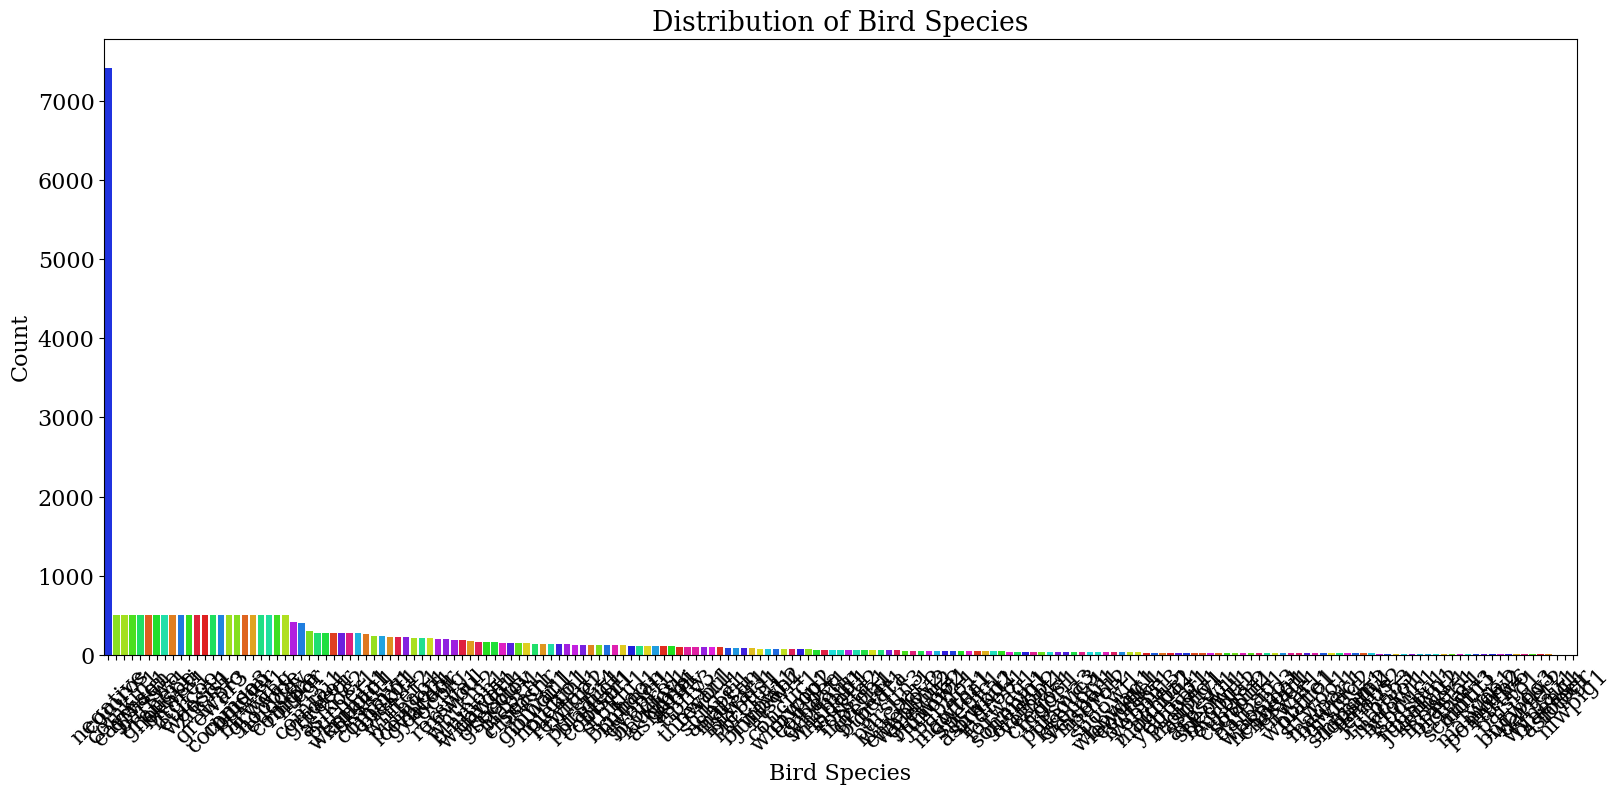

In [30]:
# Plot data distribution chart
data_distribution_chart(df_in)

Verifiquemos ahora la existencia del archivo de metadata de la base de datos de BirdCLEF24.

In [31]:
# Define the input filepath (optional)
meta_file = os.path.join(data_dir, '{}_metadata.{}'.format(sys_mode, file_ext))
# Insepct whether the file exits
os.path.exists(meta_file)

True

Definimos un método para cargar un marco de datos del archivo de entrenamiento para la base de datos BirdCLEF24.

In [32]:
def load_train_dataset(data_dir, file_name):
    # Load metadata dataframe from CSV file
    meta_file = os.path.join(data_dir, file_name)
    meta_df = pd.read_csv(meta_file)
    # Retrieve columns to drop from the dataframe of interest
    df_cols = meta_df.columns.tolist()
    drop_cols = df_cols[1:-1]
    df = meta_df.drop(columns=drop_cols)
    print('[INFO] Loading {} file as DF of {} shape...'.format(meta_file, df.shape))
    bsize = df.memory_usage(deep=True).sum()
    print('[INFO] Dataframe memory usage: {}'.format(humanize.naturalsize(bsize)))
    # Delete metadata dataframe object
    del meta_df
    # Run garbage collection
    gc.collect()
    return df

Creamos un nuevo marco de datos de entrada para su procesamiento y exploración.

In [33]:
# Generate the complete dataframe for the 182-birds species
df_in = load_train_dataset(data_dir, meta_file)

[INFO] Loading /data/fquiros/projects/birdCLEF24/datasets/train_metadata.csv file as DF of (24459, 2) shape...
[INFO] Dataframe memory usage: 3.4 MB


Grafiquemos la distribución de los datos en la estructura de entrada.

[INFO] Target bird labels: ['asbfly' 'ashdro1' 'ashpri1' 'ashwoo2' 'asikoe2' 'asiope1' 'aspfly1'
 'aspswi1' 'barfly1' 'barswa' 'bcnher' 'bkcbul1' 'bkrfla1' 'bkskit1'
 'bkwsti' 'bladro1' 'blaeag1' 'blakit1' 'blhori1' 'blnmon1' 'blrwar1'
 'bncwoo3' 'brakit1' 'brasta1' 'brcful1' 'brfowl1' 'brnhao1' 'brnshr'
 'brodro1' 'brwjac1' 'brwowl1' 'btbeat1' 'bwfshr1' 'categr' 'chbeat1'
 'cohcuc1' 'comfla1' 'comgre' 'comior1' 'comkin1' 'commoo3' 'commyn'
 'compea' 'comros' 'comsan' 'comtai1' 'copbar1' 'crbsun2' 'cregos1'
 'crfbar1' 'crseag1' 'dafbab1' 'darter2' 'eaywag1' 'emedov2' 'eucdov'
 'eurbla2' 'eurcoo' 'forwag1' 'gargan' 'gloibi' 'goflea1' 'graher1'
 'grbeat1' 'grecou1' 'greegr' 'grefla1' 'grehor1' 'grejun2' 'grenig1'
 'grewar3' 'grnsan' 'grnwar1' 'grtdro1' 'gryfra' 'grynig2' 'grywag'
 'gybpri1' 'gyhcaf1' 'heswoo1' 'hoopoe' 'houcro1' 'houspa' 'inbrob1'
 'indpit1' 'indrob1' 'indrol2' 'indtit1' 'ingori1' 'inpher1' 'insbab1'
 'insowl1' 'integr' 'isbduc1' 'jerbus2' 'junbab2' 'junmyn1' 'junowl1'
 

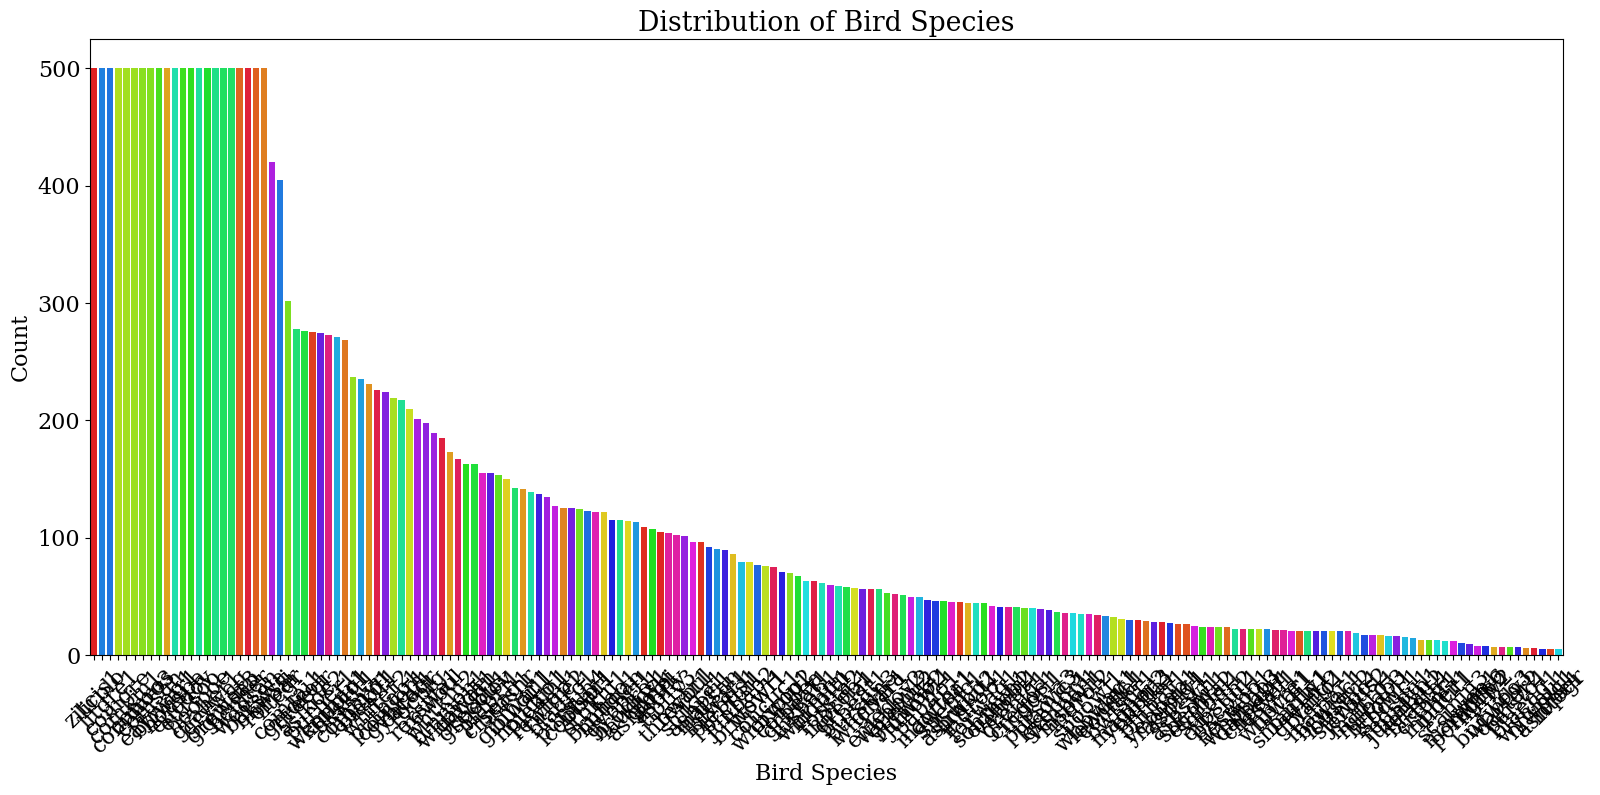

In [34]:
# Store data distribution chart
data_distribution_chart(df_in)

Con el fin de balancear las clases rápidamente en el conjunto de datos, instanciamos un método que retorne una estructura de datos que maneje las clases y las muestras correspondientes al conteo máximo en el set.

In [35]:
def get_df_classes_max_count(df):
    # Define an empty dataframe
    df_tmp = pd.DataFrame()
    # Create dataframe of classes from train dataframe
    df_classes = df.primary_label
    # Obtain distribution of the categories dataframe
    df_dist = df_classes.value_counts()
    # Get the data distribution with max. number of samples
    max_dist = df_dist[df_dist == df_dist.max()]
    # Retrieve the corresponding indexes (i.e., labels)
    max_index = max_dist.index
    # Convert to list and sort it
    idx_list = max_index.tolist()
    idx_list.sort()
    # Iterate through list of labels
    for i in idx_list:
        df_in = df[df_classes == i]
        df_tmp = pd.concat([df_tmp, df_in], ignore_index=True)
    # Create a dataframe with samples associated with max. categories
    df_out = df_tmp
    print('[INFO] Create the dataframe of interest with {} dimensions'.format(df_out.shape))
    # Display dataframe memory usage
    bsize = df_out.memory_usage(deep=True).sum()
    print('[INFO] Dataframe memory usage: {}'.format(humanize.naturalsize(bsize)))
    # Delete dataframes objects
    del df, df_tmp
    # Run garbage collector
    gc.collect()
    # Return the output dataframe
    return df_out

Obtenemos el dataframe de las vocalizaciones de especies con más repiticiones dentro del set de datos de la competición BirdCLEF 2024.

In [36]:
# Retrieve an input dataframe that considers classes with most samples
df_in = get_df_classes_max_count(df_in)

[INFO] Create the dataframe of interest with (11000, 2) dimensions
[INFO] Dataframe memory usage: 1.5 MB


Ejecutamos la visualización EDA con el fin de estudiar el balanceo de datos.

[INFO] Target bird labels: ['barswa' 'bcnher' 'bkwsti' 'blrwar1' 'comgre' 'comkin1' 'commoo3'
 'comros' 'comsan' 'eaywag1' 'eucdov' 'eurcoo' 'graher1' 'grewar3'
 'grnsan' 'grywag' 'hoopoe' 'houspa' 'lirplo' 'litgre1' 'woosan' 'zitcis1']
[INFO] Number of unique names of birds: 22
[INFO] Target bird classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


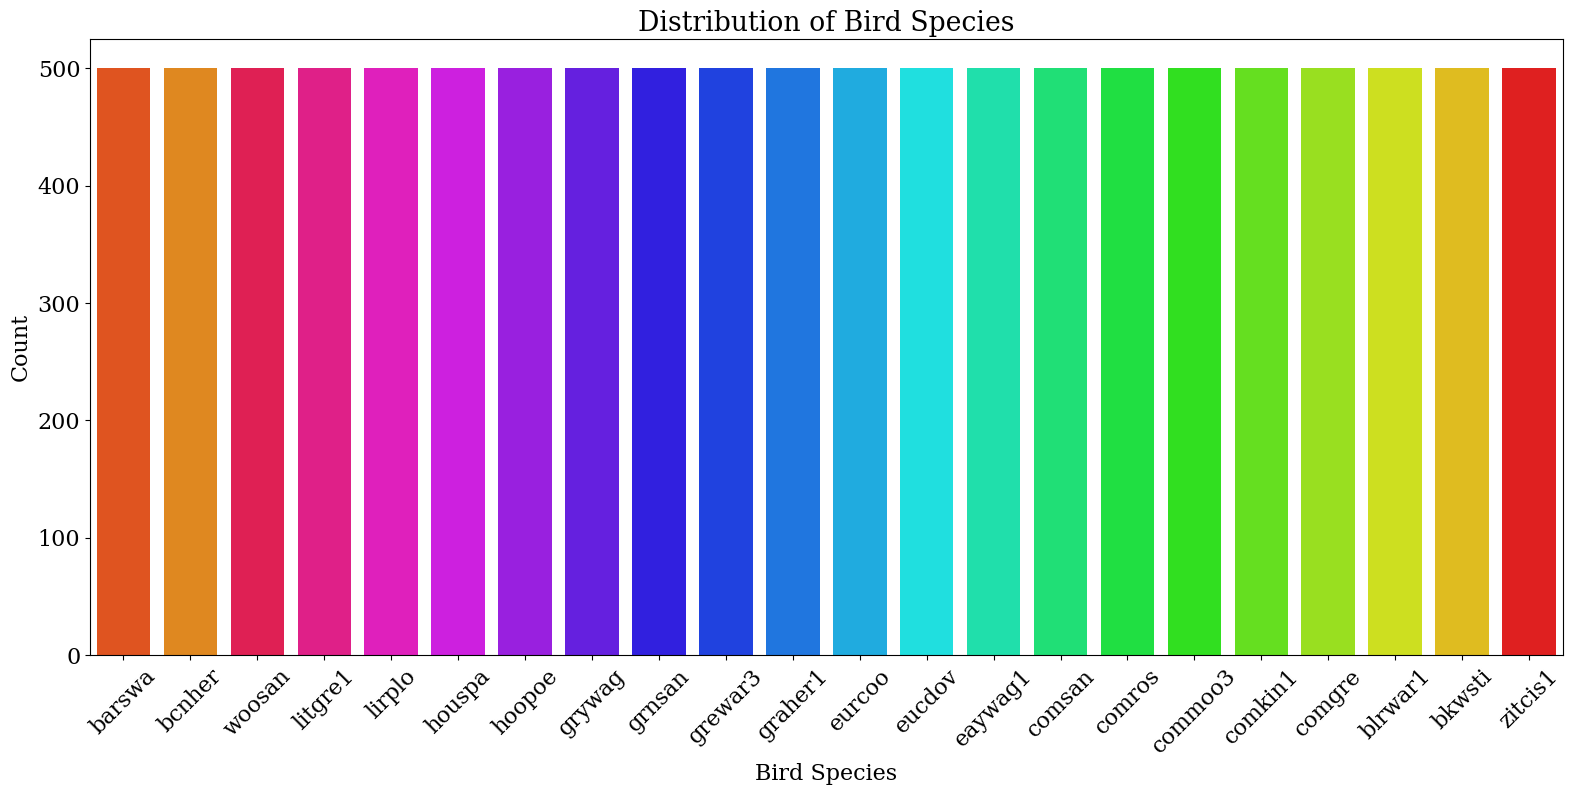

In [37]:
# Plot the data distribution chart using the maximum count dataframe
data_distribution_chart(df_in)

Obtenemos ahora la lista de las rutas de los archivos de audio y sus respetivas etiquetadas para la extración de características de estas señales.

In [38]:
# Get dataframe of labels
df_labels = df_in.primary_label
# List of target labels
labels = df_labels.values.tolist()
# Get the filenames of WAV samples
filenames = df_in.filename.values.tolist()

### Procesamiento de audio

Declaramos un método genérico para cargar las tramas de audio desde un archivo.

In [39]:
def load_audio_data(filename, sr=None, mono=True, dtype='float32', silent=False):
    # Load audio data and retrieve sampling rate
    s, fs = librosa.load(filename,
                         sr=sr,
                         mono=mono,
                         dtype=dtype)
    Ts = 1 / float(fs)
    N = len(s)
    T = N * Ts
    if not silent:
        print('[INFO] Audio data loaded: {}, sampling rate: {}, duration: {} s'.format(filename, fs, T))
    return s, fs, T

Definimos una función para efectuar sub-muestreo y sobre-muestreo.

In [40]:
def resampling(signal, src_fs, dst_fs=None, dtype='float32', silent=False):
    # update source sampling rate
    fs = src_fs
    # adjust data type
    audio = signal.astype(dtype)
    # if: check the resampling enable
    if dst_fs is not None:
        # compare current fs and eventual fs
        if dst_fs < src_fs:
            # downsampling
            if not silent:
                print('[INFO] Downsampling ({}->{}) audio track'.format(src_fs, dst_fs))
            audio_down = librosa.resample(y=audio, orig_sr=src_fs, target_sr=dst_fs)
            audio = audio_down.astype(dtype)
            fs = dst_fs
        elif dst_fs > src_fs:
            # upsampling
            if not silent:
                print('[INFO] Upsampling ({}->{}) audio track'.format(src_fs, dst_fs))
            audio_up = librosa.resample(y=audio, orig_sr=src_fs, target_sr=dst_fs)
            audio = audio_up.astype(dtype)
            fs = dst_fs
        else:
            # no resampling
            if not silent:
                print('[INFO] No resampling ({}->{}) audio track'.format(src_fs, dst_fs))
            return audio, fs
    # else: no resampling
    return audio, fs

Establecemos un método para graficar el archivo de audio en el dominio del tiempo.

In [41]:
def plot_audio_signal(s, fs, tag, path=None, markers=np.array([])):
    fig = plt.figure()
    Ts = 1 / float(fs)
    N = len(s)
    T = N * Ts
    t = np.arange(N) * Ts
    if markers.size != 0:
        # Normalize signal for marked plots
        s = s / np.amax(s)
        print('[INFO] Amount of signal markers: {}'.format(len(markers)))
        plt.vlines(markers, s.min(), s.max(), color='orange')
        plt.ylim(s.min(), s.max())
    plt.plot(t, s)
    plt.xlim(0, T)
    plt.title('Audio signal plot'.format(tag))
    plt.grid(True)
    plt.xlabel('Time [s]')
    plt.ylabel('Gain')
    if path is None:
        plt.show()
    else:
        imgpath = os.path.join(path, '{}_signal.pdf'.format(tag))
        fig.savefig(imgpath)
        print('[INFO] Saving plot file of audio signal: {}'.format(imgpath))
        plt.close(fig)
    del fig
    gc.collect()

Definimos un índice de forma aleatoria para obtener una muestra de audio de la lista de archivos de audio.

In [42]:
# define a random index of audio files
rand_value = random.sample(range(len(df_in)), 1)
index = int(rand_value[0])
audio_file = os.path.join(train_dir, filenames[index])
label_file = labels[index]
audio_file, label_file

('/data/fquiros/projects/birdCLEF24/datasets/train_audio/eucdov/XC760696.ogg',
 'eucdov')

Cargamos el archivo de audio determinado de forma aleatoria de la lista de nombres de archivos de audio.

In [43]:
# perform waveform extraction
waveform, sampling_rate, duration = load_audio_data(audio_file, silent=False)

[INFO] Audio data loaded: /data/fquiros/projects/birdCLEF24/datasets/train_audio/eucdov/XC760696.ogg, sampling rate: 32000, duration: 5.3020000000000005 s


Desplegamos una representación en el dominio del tiempo de la señal de audio, así como un reproductor del archivo de audio, para analizar auditivamente la muestra en cuestión.

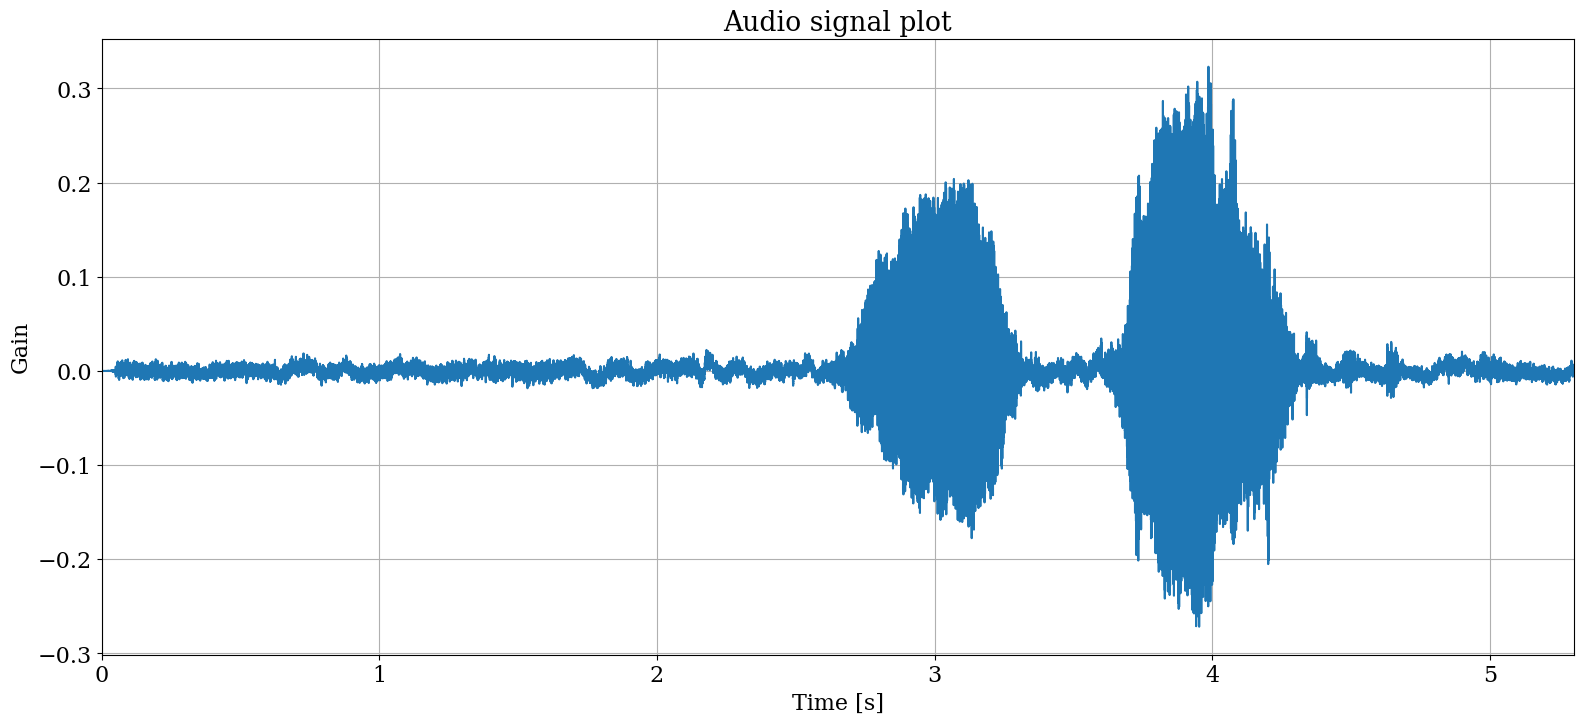

In [44]:
sample_tag = '{}:{}:{}'.format(index, audio_file, label_file)
plot_audio_signal(waveform, sampling_rate, sample_tag)
# Enable Python player
IPython.display.Audio(audio_file)

## Extracción de características

Establecemos distintos métodos que conforman la secuencias de pasos que conforma la extracción de características (*feature extraction*, FE), donde transformas las muestras de audio en representaciones de audio que se adecuan a modelos de aprendizaje profundo.

Primero, definimos la función de un filtrado pasa-altas para remover ruido de baja frecuencia.

In [45]:
def high_pass_filter(s, fs, f_ord, f_hpf):
    nyq = fs*0.5
    f_cut = f_hpf/nyq
    b, a = butter(f_ord, f_cut, 'hp')
    x = lfilter(b, a, s)
    return b, a, x

Instanciamos un método para efectuar la separación fuentes sonoras harmónicas usando la magnitud del espectrograma de audio.

In [46]:
def harmonic_source_separation(S_mag,
                               hfilt_width=5,
                               pfilt_width=27,
                               hmask_margin=7,
                               pmask_margin=1):
    # Harmonic filter size and margin
    kernel_size = (hfilt_width, pfilt_width)
    margin = (hmask_margin, pmask_margin)
    # HPSS stage
    H_mag, _ = hpss(S=S_mag, kernel_size=kernel_size, margin=margin)
    # Return harmonic spectrum magnitude
    return H_mag

Declaramos ahora funciones y rutinas útiles para ejecutar la conversión de una representación en 1D a otra en 2D, así como su respecitva visualización. Para este caso, nos enfocamos principalmente en los espectrogramas en escala de Mel.

In [47]:
def stft_magnitude(s, sr, n_fft, hop_length, win='hann'):
    # hann window by default: periodic window for spectral analysis
    f, t, S_mag = stft(x=s,
                       fs=sr,
                       window=win,
                       nperseg=n_fft,
                       noverlap=hop_length,
                       nfft=n_fft,
                       scaling='spectrum')
    return t, f, S_mag

Instanciamos un método alternativo para generar la magnitud espectral utilizando transformadas sucesivas de Fourier empleando la librería `scipy`.

In [48]:
def spectral_magnitude(s, sr, n_fft, hop_length, win='hann'):
    # hann window by default: periodic window for spectral analysis
    f, t, S_mag = spectrogram(x=s,
                              fs=sr,
                              window=win,
                              nperseg=n_fft,
                              noverlap=hop_length,
                              nfft=n_fft,
                              scaling='spectrum',
                              mode='magnitude')
    return t, f, S_mag

Define a method to generate a Mel-spectrogram.

In [49]:
def mel_spectrogram(s, sr, n_fft, hop_length, n_mels, win='hann'):
    # compute mel-spectrogram
    S = librosa.feature.melspectrogram(y=s, sr=sr,
                                       n_fft=n_fft,
                                       hop_length=hop_length,
                                       window=win,
                                       n_mels=n_mels)
    # mel-spectrogram magnitude
    S_mag = np.abs(S)
    # time and frequency coefficients
    t = librosa.frames_to_time(np.arange(S_mag.shape[1]), sr=sr, hop_length=hop_length)
    f = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    return t, f, S_mag

Declaramos un método para graficar el espectrograma de entrada en dB.

In [50]:
def plot_spectrogram(S_dB, t, f, title):
    plt.pcolormesh(t, f, S_dB)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Power spectrogram in dB - {}'.format(title))
    plt.show()

Define a function to plot Mel-spectrogram.

In [51]:
def plot_mel_spectrogram(S_dB, sr, hop_length, title, y_axis='hz'):
    specshow(S_dB, sr=sr, hop_length=hop_length, x_axis='time', y_axis=y_axis)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-spectrogram in dB - {}'.format(title))
    plt.show()

Establish the input arguments of the feature extraction to get a spectral representation of labeled audio samples.

In [52]:
# mel-spectrogram parameters
n_fft = 2046
mel_bands = 104
fft_overlap = 0.5
hop_length = int(n_fft * (1 - fft_overlap))

Calculamos la magnitud spectral en escala de Mel como representación de características de la señal de entrada.

In [53]:
_, _, S_mag = mel_spectrogram(s=waveform,
                              sr=sampling_rate,
                              n_fft=n_fft,
                              hop_length=hop_length,
                              n_mels=mel_bands)

Generamos el espectrogram mediante la conversión de la magnitud en escala Mel a dB y lo graficamos.

[INFO] MFCC: Mel-spectrogram array - dtype: float32, (freq. bin x time frames): (104, 166), dtype: float32


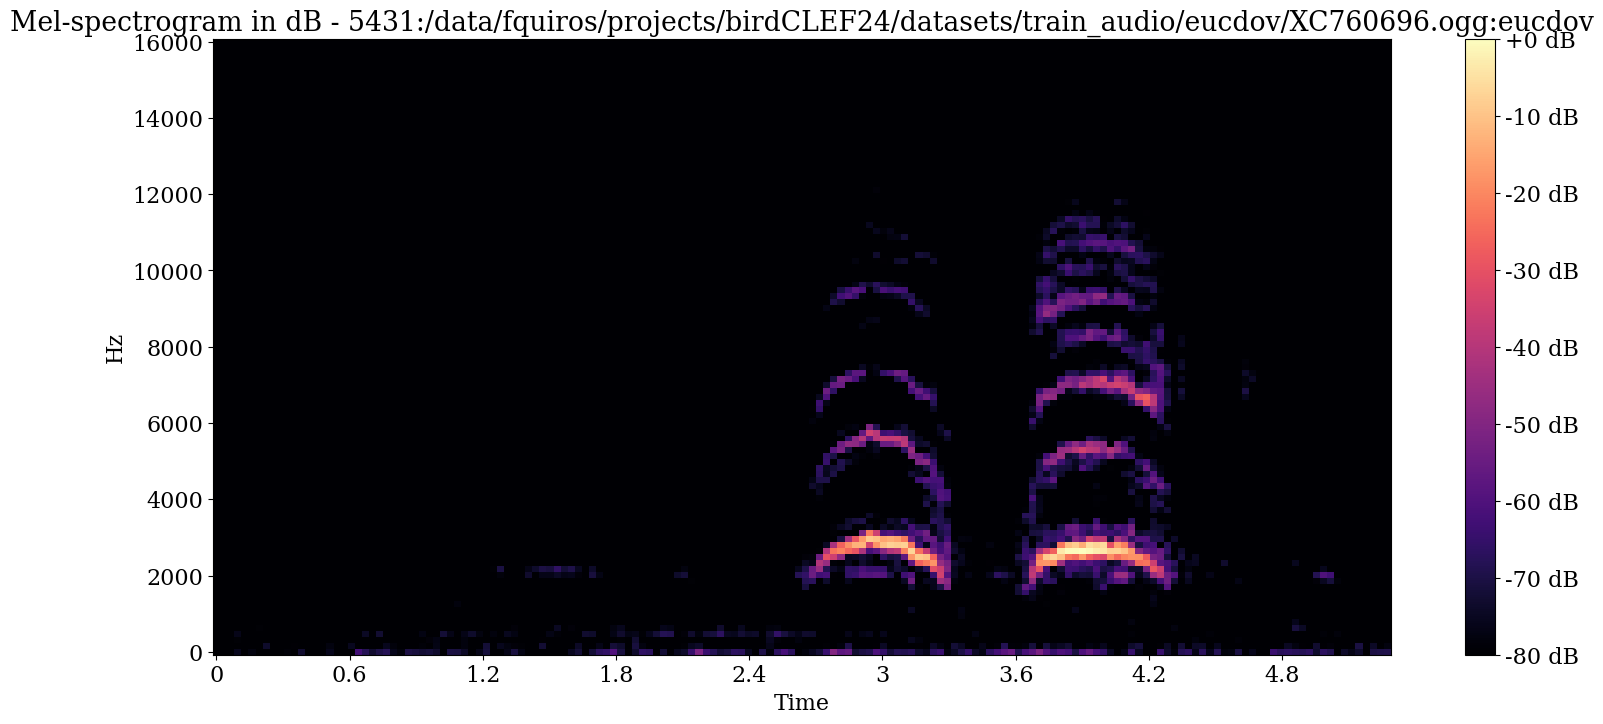

In [54]:
S_dB = librosa.amplitude_to_db(S_mag, ref=np.max)
print('[INFO] MFCC: Mel-spectrogram array - dtype: {}, (freq. bin x time frames): {}, dtype: {}'.format(S_dB.dtype, S_dB.shape, S_dB.dtype))
plot_mel_spectrogram(S_dB=S_dB, sr=sampling_rate, hop_length=hop_length, title=sample_tag)

Filtramos la señal de entrada para remover el sonido de baja frecuencia (orden 4, corte$@2kHz$). Graficamos la señal en el dominio del tiempo.

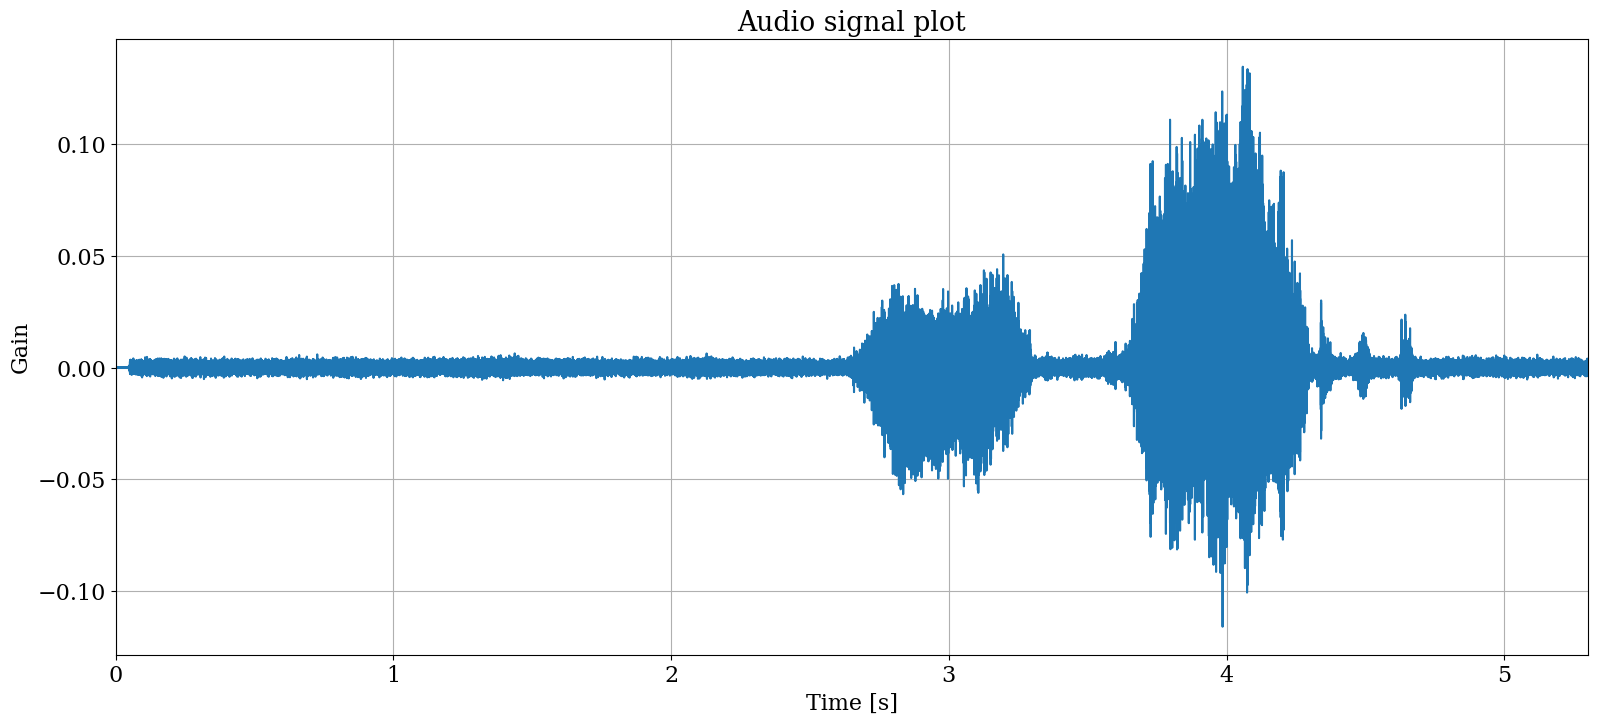

In [55]:
# filtered the input waveform
_, _, waveform = high_pass_filter(waveform,
                                  sampling_rate,
                                  f_ord=4,
                                  f_hpf=2000)
plot_audio_signal(waveform, sampling_rate, sample_tag)

Calculamos y graficamos el espectrograma en escala de Mel de la señal filtrada.

[INFO] MFCC: Mel-spectrogram array - dtype: float64, (freq. bin x time frames): (104, 166), dtype: float64


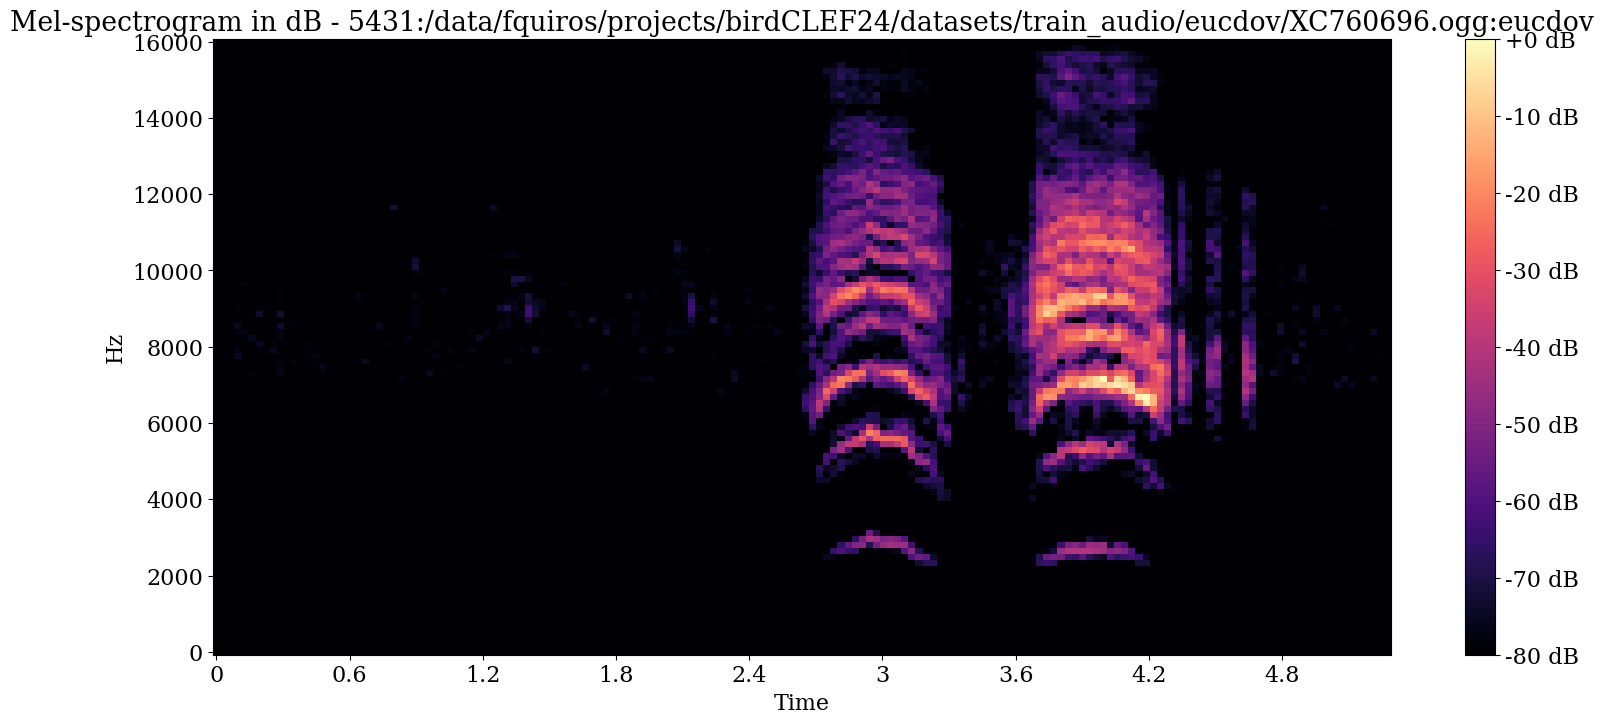

In [56]:
_, _, S_mag = mel_spectrogram(s=waveform,
                              sr=sampling_rate,
                              n_fft=n_fft,
                              hop_length=hop_length,
                              n_mels=mel_bands)
S_dB = librosa.amplitude_to_db(S_mag, ref=np.max)
print('[INFO] MFCC: Mel-spectrogram array - dtype: {}, (freq. bin x time frames): {}, dtype: {}'.format(S_dB.dtype, S_dB.shape, S_dB.dtype))
plot_mel_spectrogram(S_dB=S_dB, sr=sampling_rate, hop_length=hop_length, title=sample_tag)

Normalizamos la señal filtrada.

In [57]:
# normalized the filtered signal
waveform = waveform / np.amax(waveform)

Aplicamos el algoritmo de reducción de ruido basado en *spectral gating* para suprimir el ruido de fondo.

In [58]:
waveform = nr.reduce_noise(y=waveform,
                           sr=sampling_rate,
                           n_fft=n_fft,
                           hop_length=hop_length)

Graficamos la señal normalizada sin ruido.

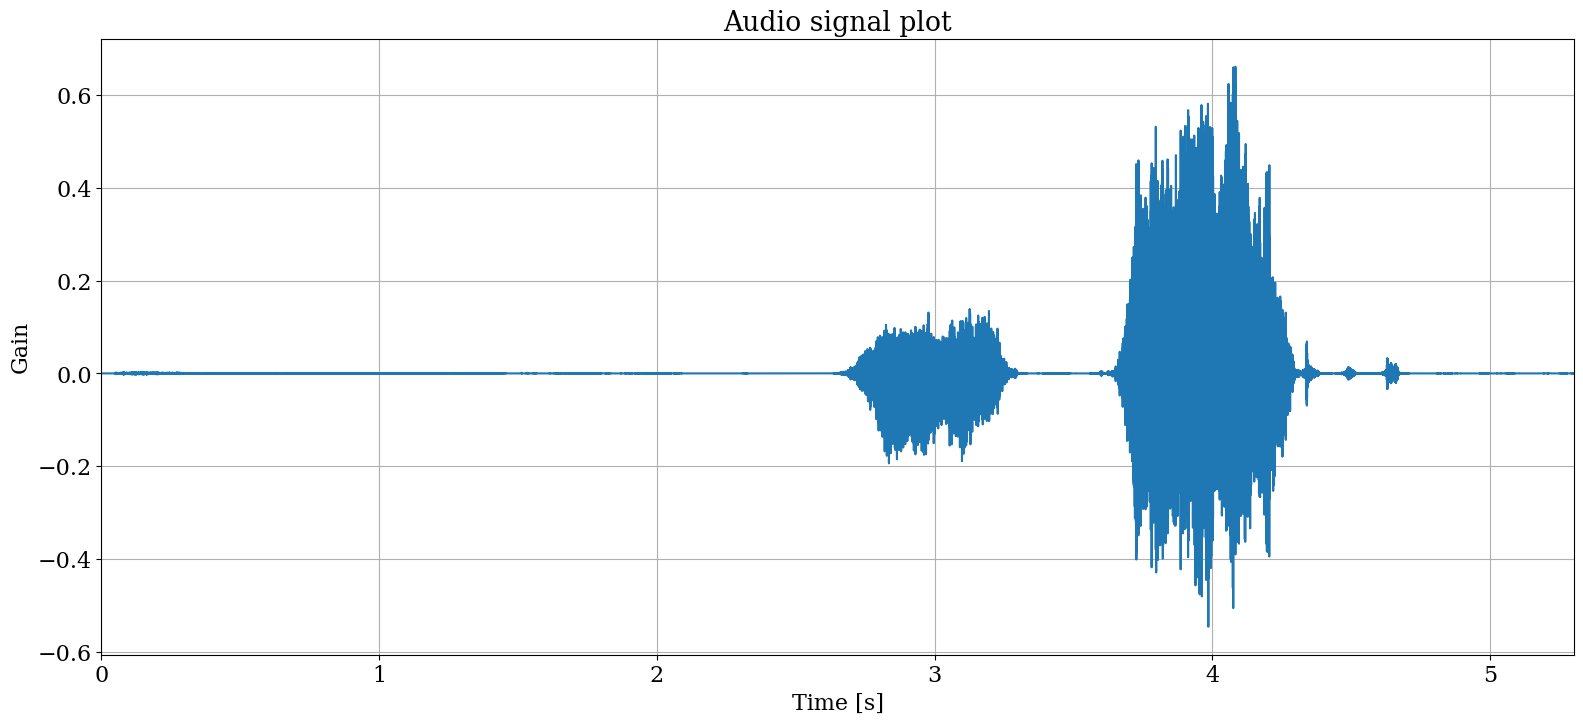

In [59]:
plot_audio_signal(waveform, sampling_rate, sample_tag)

Calculamos y desplegamos el espectrograma en escala de Mel de la señal sin ruido junto con la separación de fuentes harmónicas.

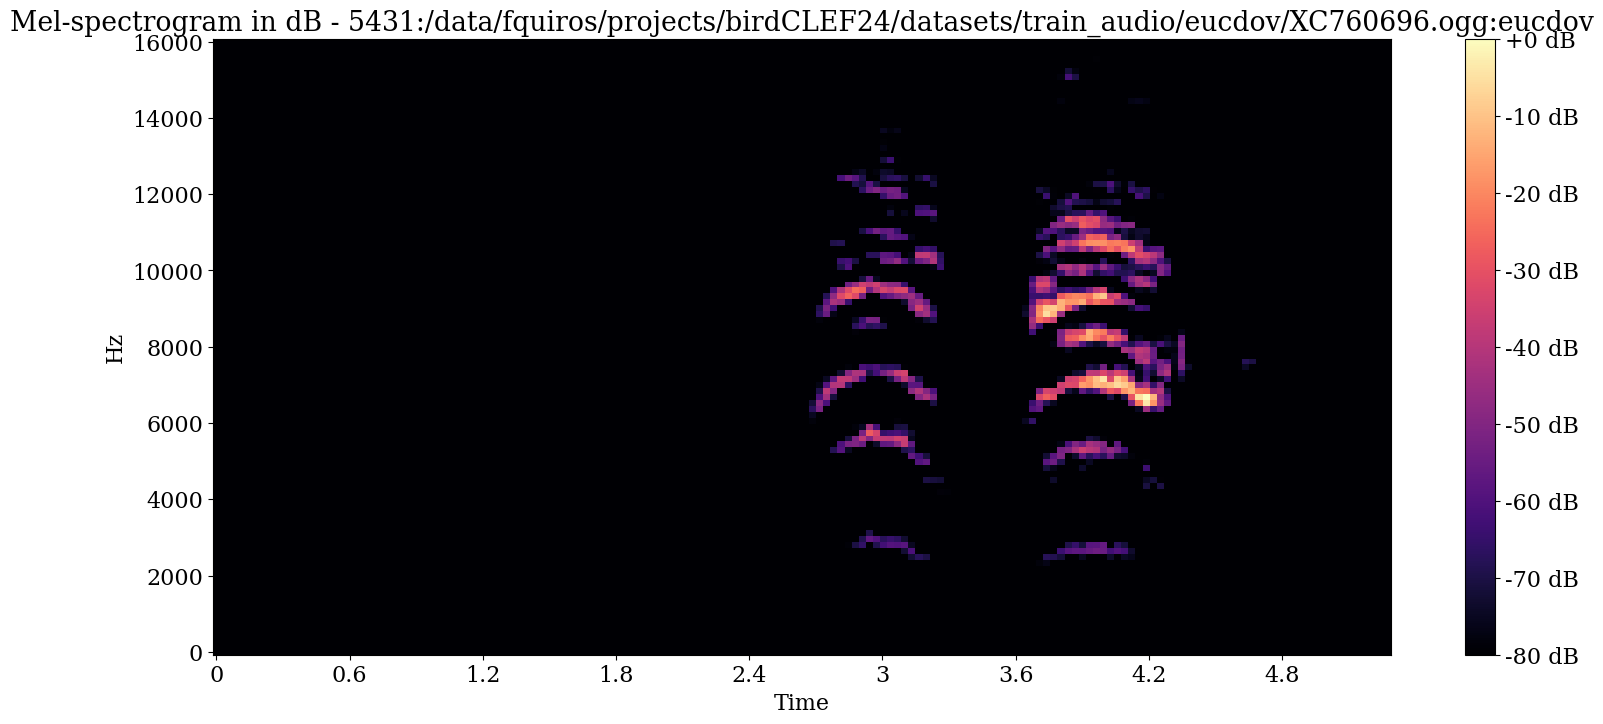

In [60]:
_, _, S_mag = mel_spectrogram(s=waveform,
                              sr=sampling_rate,
                              n_fft=n_fft,
                              hop_length=hop_length,
                              n_mels=mel_bands)
# perform harmonic source separation
S_mag = harmonic_source_separation(S_mag)
# convert amplitude to dB
S_dB = librosa.amplitude_to_db(S_mag, ref=np.max)
plot_mel_spectrogram(S_dB=S_dB, sr=sampling_rate, hop_length=hop_length, title=sample_tag)

Despleguemos una muestra espectral en dB como un arreglo de datos.

[INFO] Plot Mel-spectrogram magnitude as image array: (104, 166)


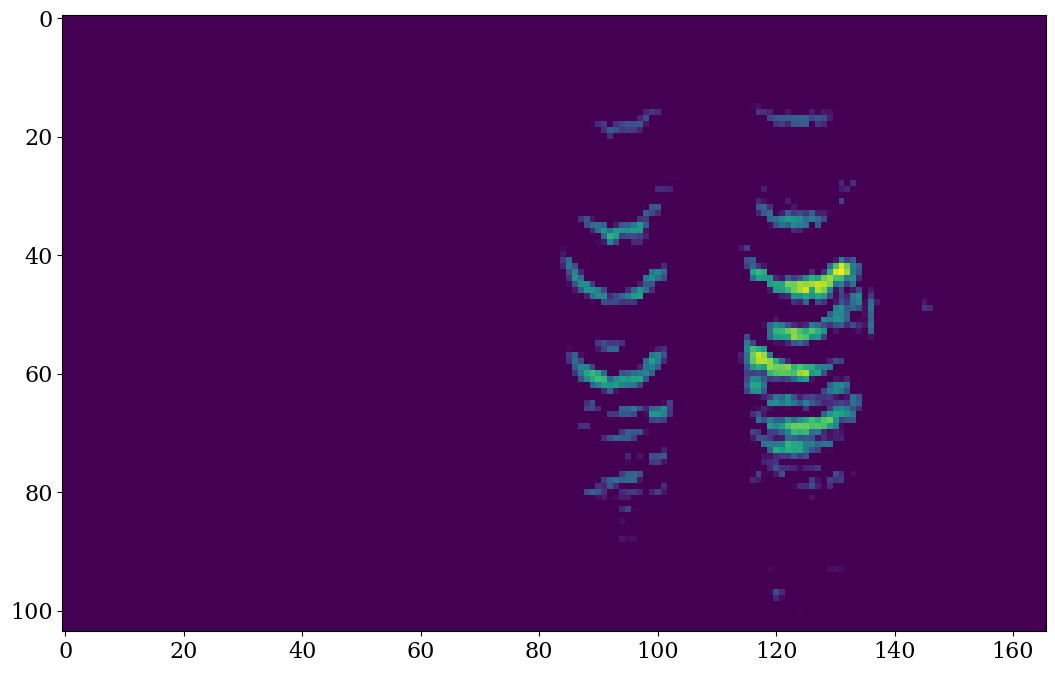

In [61]:
print('[INFO] Plot Mel-spectrogram magnitude as image array: {}'.format(S_dB.shape))
plt.imshow(S_dB)

Define image processing constants.

In [62]:
# define pixel values
img_depth, img_val = 3, 255.0
# define dimensions of the resizing method
img_height, img_width = 256, 256
img_dims = (img_height, img_width)
# define interpolation method for resizing
intpol = cv.INTER_AREA

Perform spectrogram normalization for image processing.

In [63]:
# spectrogram normalization
S_dB -= S_dB.min()
# update normalized spectrogram in dB
S_dB /= (S_dB.max()- S_dB.min())

Execute image shrinking and flipping to the input spectrogram.

In [64]:
# shrink the image
S_img = cv.resize(S_dB,
                  img_dims,
                  interpolation=intpol)
# flip image
S_img = cv.flip(S_img, 0)
print('[INFO] Spectral image resized and flipped: {}'.format(S_img.shape))

[INFO] Spectral image resized and flipped: (256, 256)


Ejecutamos una conversión de espacio de color a RGB o escala de grises.

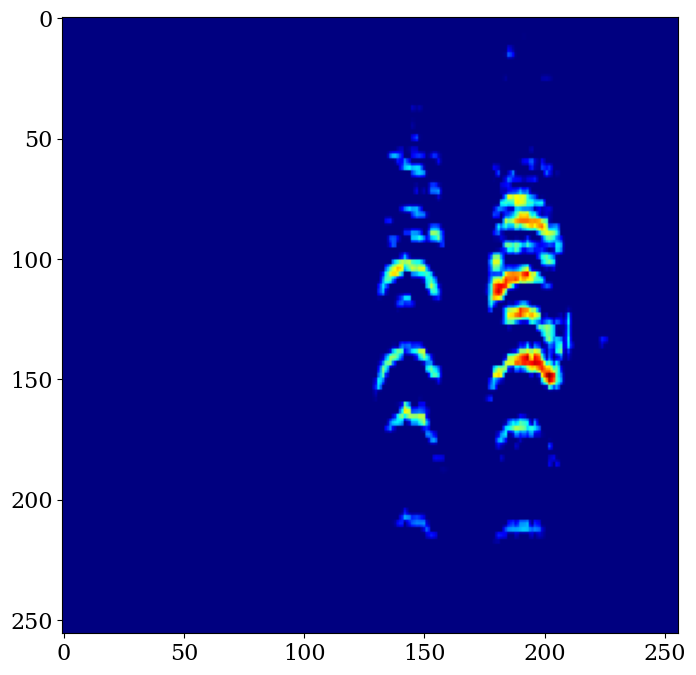

In [65]:
# color space conversion
S_img = (S_img * img_val).astype(np.uint8)
# apply JET color map as BGR format
S_img = cv.applyColorMap(S_img, cv.COLORMAP_JET)
if img_depth == 1:
    # BGR2GRAY grayscale images
    S_img = cv.cvtColor(S_img, cv.COLOR_BGR2GRAY)
    plt.imshow(S_img, cmap='gray')
else:
    # BGR2RGB color images
    S_img = cv.cvtColor(S_img, cv.COLOR_BGR2RGB)
    plt.imshow(S_img, cmap='jet')

Verifiquemos la escritura de imágenes en el sistema de archivos utilizando este ejemplo.

In [66]:
# Define the image file extension
img_ext = 'jpeg'
# Define the image input directory
img_dir = '{}/{}_imgs'.format(data_dir, sys_mode)
# Get audio tag
sample_tag = audio_file.split('/')[-2:][1].split('.')[0]
# Retrieve image filepath
img_sample = [sample_tag, img_ext]
img_sample = '.'.join(img_sample)
img_sample = '{}/{}'.format(label_file, img_sample)
img_path = os.path.join(img_dir, img_sample)
print(img_path)
# Store spectrogram as an image
#plt.imsave(img_path, S_img)
cv.imwrite(img_path, S_img)
# Set env variable with image filepath

/data/fquiros/projects/birdCLEF24/datasets/train_imgs/eucdov/XC760696.jpeg


True

Desde el sistema de archivos, revisemos desde la consola del sistema la creación de la imagen correspondiente en formato JPEG

In [67]:
!ls -lha /data/fquiros/projects/birdCLEF24/datasets/train_imgs/eucdov/XC760696.jpeg

-rw-r--r-- 1 fquiros cluster 9.9K Sep 18 19:40 /data/fquiros/projects/birdCLEF24/datasets/train_imgs/eucdov/XC760696.jpeg


Carguemos los datos de la imagen JPEG previamente creada y mostremos su contenido usando `matplotlib`.

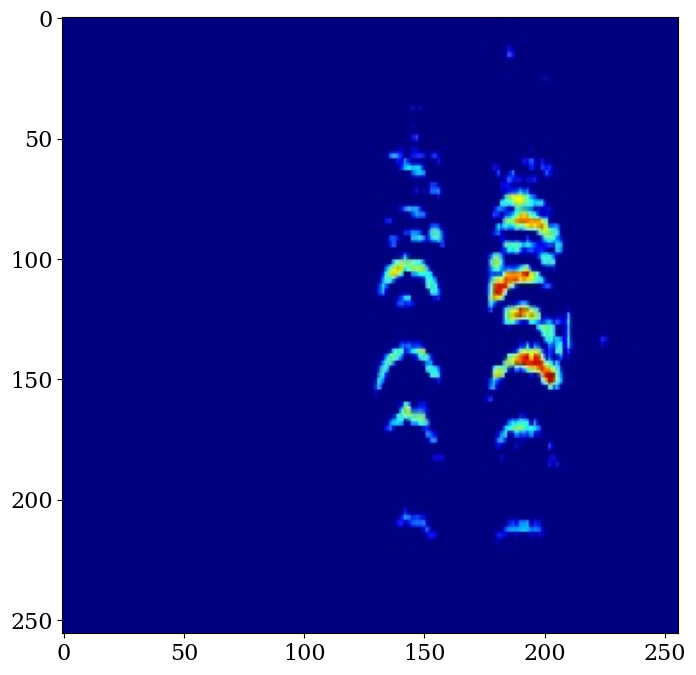

In [68]:
# get image without changes
image = cv.imread(img_path)
plt.imshow(image)

Define a function to create a pipeline to pre-process and convert 1D-signal to 2D-images.

In [69]:
def gen_mel_spectral_image(filename,
                           n_fft,
                           hop_length,
                           mel_bands,
                           img_val,
                           img_depth,
                           img_dims,
                           train_dir=None,
                           dst_sr=None,
                           den=False,
                           f_ord=4,
                           f_hpf=2000,
                           int_pol=cv.INTER_AREA):
    # define filepath to load audio sample
    if train_dir == None:
        filepath = filename
    else:
        filepath = os.path.join(train_dir, filename)
    # perform waveform loading
    wav_data, sampling_rate, duration = load_audio_data(filename=filepath, silent=True)
    # resampling waveform
    wav_data, sampling_rate = resampling(wav_data, sampling_rate, dst_fs=dst_sr, silent=True)
    # denoising routine
    if den:
        # high-pass filtering
        _, _, wav_data = high_pass_filter(wav_data,
                                          sampling_rate,
                                          f_ord=f_ord,
                                          f_hpf=f_hpf)
        # normalize audio signal
        wav_data = wav_data / np.amax(wav_data)
        # apply noise reduction
        wav_data = nr.reduce_noise(y=wav_data,
                                   sr=sampling_rate,
                                   n_fft=n_fft,
                                   hop_length=hop_length)

    # compute mel-spectrogram in dB
    _, _, S_mag = mel_spectrogram(s=wav_data,
                                  sr=sampling_rate,
                                  n_fft=n_fft,
                                  hop_length=hop_length,
                                  n_mels=mel_bands)
    # final denoising step
    if den:
        # perform harmonic source separation
        S_mag = harmonic_source_separation(S_mag)

    # convert to dB
    S_dB = librosa.amplitude_to_db(S_mag, ref=np.max)
    # spectrogram normalization
    S_dB -= S_dB.min()
    # update normalized spectrogram in dB
    S_dB /= (S_dB.max()- S_dB.min())

    # shrink the image
    S_img = cv.resize(S_dB,
                      img_dims,
                      interpolation=intpol)
    # flip image
    S_img = cv.flip(S_img, 0)
    # color space conversion
    S_img = (S_img * img_val).astype(np.uint8)
    # apply JET color map as BGR format
    S_img = cv.applyColorMap(S_img, cv.COLORMAP_JET)
    # check number of channels
    if img_depth == 1:
        # BGR2GRAY grayscale images
        S_img = cv.cvtColor(S_img, cv.COLOR_BGR2GRAY)
    else:
        # BGR2RGB color images
        S_img = cv.cvtColor(S_img, cv.COLOR_BGR2RGB)

    # Delete intermediate outputs
    del wav_data, S_mag, S_dB
    # Run garbage collector
    gc.collect()
    # return spectral image
    return S_img

Define a method to extract spectral images by iterating through the train directory and applying audio processing to the data for spectral image generation.

In [70]:
def get_mel_spectral_data(filenames,
                          in_dir,
                          n_fft,
                          fft_overlap,
                          mel_bands,
                          img_val,
                          img_depth,
                          img_dims,
                          dir_tag='train',
                          labels=None,
                          dst_sr=None,
                          img_ext=None):
    # Objects initialization
    spec_imgs, spec_labels, spec_samples = list(), list(), list()  # List of spectral images and its label
    # Define hop length for spectrogram
    hop_length = int(n_fft * (1 - fft_overlap))
    # Iterate throught a list of filenames
    for i, fn in enumerate(filenames):
        # Define training directory: input
        data_dir = '{}/{}_audio'.format(in_dir, dir_tag)
        # Get the corresponding file
        filename = fn
        # Define the label value according the input
        if labels is None:
            # Invalid value
            wav_label = np.NaN
        else:
            # Valid bird category
            wav_label = labels[i]

        # Create spectral image for a list of training files
        S_img = gen_mel_spectral_image(filename,
                                       n_fft,
                                       hop_length,
                                       mel_bands,
                                       img_val,
                                       img_depth,
                                       img_dims,
                                       data_dir,
                                       dst_sr,
                                       den=True)
        # increase sample count
        img_cnt = i + 1
        # Verify whether image is invalid or not
        nan_img = np.isnan(S_img).any()
        # verification
        if nan_img:
            print('[WARN] Audio-FE {}/{} [{}]: Invalid spectral image [{}]'.format(img_cnt,
                                                                                   len(filenames),
                                                                                   filename,
                                                                                   wav_label))
        else:
            # Check whether the image storage is enabled or not
            if img_ext is None:
                # Update spectral images list
                spec_imgs.append(S_img)
                # Update labels list
                spec_labels.append(wav_label)
            else:
                # Update training directory as images
                data_dir = '{}/{}_imgs'.format(in_dir, dir_tag)
                # Try to create a new directory for the incoming spectral images
                try:
                    os.makedirs(data_dir)
                    print('[INFO] Create a directory for spectral images: {}'.format(data_dir))
                # skip directory generation
                except OSError as oe:
                    # Raise OSError when the directory exists
                    if oe.errno != errno.EEXIST:
                        raise
                # Check if label is invalid
                if pd.isnull(wav_label):
                    # define JPEG path
                    img_dir = data_dir
                else:
                    # define JPEG path
                    img_dir = os.path.join(data_dir, wav_label)
                    # create the corresponding directory if it does not exist
                    try:
                        os.makedirs(img_dir)
                        print('[INFO] Create images directory for a target class: {}'.format(img_dir))
                    # skip directory generation
                    except OSError as oe:
                        # raise OSError when the directory exists
                        if oe.errno != errno.EEXIST:
                            raise

                # Store images as JPEG files
                spec_file = store_spectral_image(S_img, wav_label, filename, img_ext, img_dir)
                # Append image observation to list
                spec_samples.append(spec_file)

            # Display basic sample info
            print('[INFO] Audio-FE {}/{} [{}]: Spectral image [{}] - dtype = {}, dims = {}'.format(img_cnt,
                                                                                                   len(filenames),
                                                                                                   filename,
                                                                                                   wav_label,
                                                                                                   S_img.dtype,
                                                                                                   S_img.shape))

        # delete spectral image object
        del S_img
        # run garbage collector
        gc.collect()

    if img_ext is None:
        # convert the list of spectral images into an array
        data = np.stack(spec_imgs, axis=0)
        # get array of classes
        classes = np.array(spec_labels)
        # delete list of spectral images
        del spec_imgs, spec_labels
        # run garbage collector
        gc.collect()
        # data array dimensions with its labels
        print('[INFO] {} data array of type {} with {} labels'.format(data.shape, data.dtype, classes.shape))
        return data, classes
    else:
        # define transcription filename
        meta_file = os.path.join(in_dir, '{}_img_metadata.{}'.format(dir_tag, 'csv'))
        # create a transcription file of the labeled dataset
        create_dataset_file(meta_file, spec_samples)
        # delete object functions
        del spec_samples
        # run garbage collector
        gc.collect()

Exercise the FE method to get a data array with Mel-spectrogram of WAV samples from multi-species of birds. Perform time measurement of this module.

In [ ]:
# feature extraction - Mel-spectrogram images
t0 = time.process_time() # time measurement
# execute FE method
data, classes = get_mel_spectral_data(filenames,
                                      data_dir,
                                      n_fft,
                                      fft_overlap,
                                      mel_bands,
                                      img_val,
                                      img_depth,
                                      img_dims,
                                      dir_tag='train',
                                      labels=labels,
                                      dst_sr=sampling_rate)
# run garbage collector
gc.collect()
# GPU seconds elapsed (FE)
t1 = time.process_time() - t0
print('[INFO] Data features extraction - duration = {:.3f}s'.format(float(t1)))
# GPU seconds to hours-minutes-seconds format
th, tm, ts = s2hms(t1)
print('[INFO] Data features extraction - duration = ({:.3f} h, {:.3f} min, {:.3f} s)'.format(float(th),
                                                                                             float(tm),
                                                                                             float(ts)))

## Estructura de datos

Dentro de nuestro dataset personalizado, contamos con imágenes pre-generadas, puesto que la extracción de características desde archivos de audio resulta ser más extensivo en comparación a tener las imágenes espectrales listas.

In [71]:
%ls /data/fquiros/projects/birdCLEF24/datasets

20240918-193253_train.csv  findsounds.tar.gz      train_audio/
birdclef-2024.zip          sample_submission.csv  train_img_metadata.csv
eBird_Taxonomy_v2021.csv   test_audio/            train_imgs/
findsounds/                test_soundscapes/      train_metadata.csv


In [72]:
%ls /data/fquiros/projects/birdCLEF24/datasets/train_imgs

barswa/  blrwar1/  commoo3/  eaywag1/  graher1/  grywag/  lirplo/   zitcis1/
bcnher/  comgre/   comros/   eucdov/   grewar3/  hoopoe/  litgre1/
bkwsti/  comkin1/  comsan/   eurcoo/   grnsan/   houspa/  woosan/


Actualizamos argumentos de entrada a la etapa de procesamiento de imágenes.

In [73]:
# Define image extension
img_ext = 'png'
# Update training directory
train_dir = '{}/{}_imgs'.format(data_dir, sys_mode)
# Define timestamp for training metadata
ts = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
# Define the input filepath
meta_file = os.path.join(data_dir, '{}_{}_imgs.{}'.format(ts, sys_mode, file_ext))
train_dir, meta_file

('/data/fquiros/projects/birdCLEF24/datasets/train_imgs',
 '/data/fquiros/projects/birdCLEF24/datasets/20240918-194057_train_imgs.csv')

Obtenemos una lista de todas las imágenes contenidas contenido en el directorio de entrenamiento.

In [74]:
# Init
train_fpaths = list()
# Get the respective filepaths of the training samples using JPEG extension
train_fpaths = find_data_samples(train_dir, ext=img_ext)

[INFO] Total data samples -> 11000:/data/fquiros/projects/birdCLEF24/datasets/train_imgs


Generamos una lista de las imágenes etiquetadas sin mezclar aleatoriamente.

In [75]:
# Labeled items for dataset transcription
train_samples = get_tagged_samples(train_fpaths, ',', shuffle=False)

Creamos una transcripción personalizada como archivo CSV de el set imágenes etiquetadas, generadas a partir de archivos de audio de la base de datos de BirdCLEF24.

In [76]:
# Run method to create CSV transcription of labeled database
create_dataset_file(meta_file, train_samples)

[INFO] Length: 11000 samples -> CSV file created!


---

Creamos un nuevo marco de datos de entrada para su procesamiento y exploración.

In [77]:
# Load CSV file to generate dataframe
df_in = load_dataset_file(meta_file, headers=['filename', 'primary_label'])

[INFO] Dataset size: (11000, 2) -> Display info of 25 samples randomly selected...
                                                filename primary_label
1691   /data/fquiros/projects/birdCLEF24/datasets/tra...       grewar3
2102   /data/fquiros/projects/birdCLEF24/datasets/tra...        eucdov
1353   /data/fquiros/projects/birdCLEF24/datasets/tra...       graher1
3547   /data/fquiros/projects/birdCLEF24/datasets/tra...       comkin1
10772  /data/fquiros/projects/birdCLEF24/datasets/tra...        grnsan
5031   /data/fquiros/projects/birdCLEF24/datasets/tra...        barswa
3594   /data/fquiros/projects/birdCLEF24/datasets/tra...       comkin1
1129   /data/fquiros/projects/birdCLEF24/datasets/tra...       graher1
10665  /data/fquiros/projects/birdCLEF24/datasets/tra...        grnsan
8270   /data/fquiros/projects/birdCLEF24/datasets/tra...        lirplo
319    /data/fquiros/projects/birdCLEF24/datasets/tra...        bkwsti
195    /data/fquiros/projects/birdCLEF24/datasets/tra...        b

Grafiquemos la distribución de los datos en la estructura de entrada, producto de la transcripción.

[INFO] Target bird labels: ['bkwsti' 'houspa' 'graher1' 'grewar3' 'eucdov' 'commoo3' 'grywag'
 'comkin1' 'zitcis1' 'blrwar1' 'barswa' 'comsan' 'comros' 'hoopoe'
 'bcnher' 'litgre1' 'lirplo' 'eaywag1' 'comgre' 'eurcoo' 'woosan' 'grnsan']
[INFO] Number of unique names of birds: 22
[INFO] Target bird classes: [ 2 17 12 13 10  6 15  5 21  3  0  8  7 16  1 19 18  9  4 11 20 14]


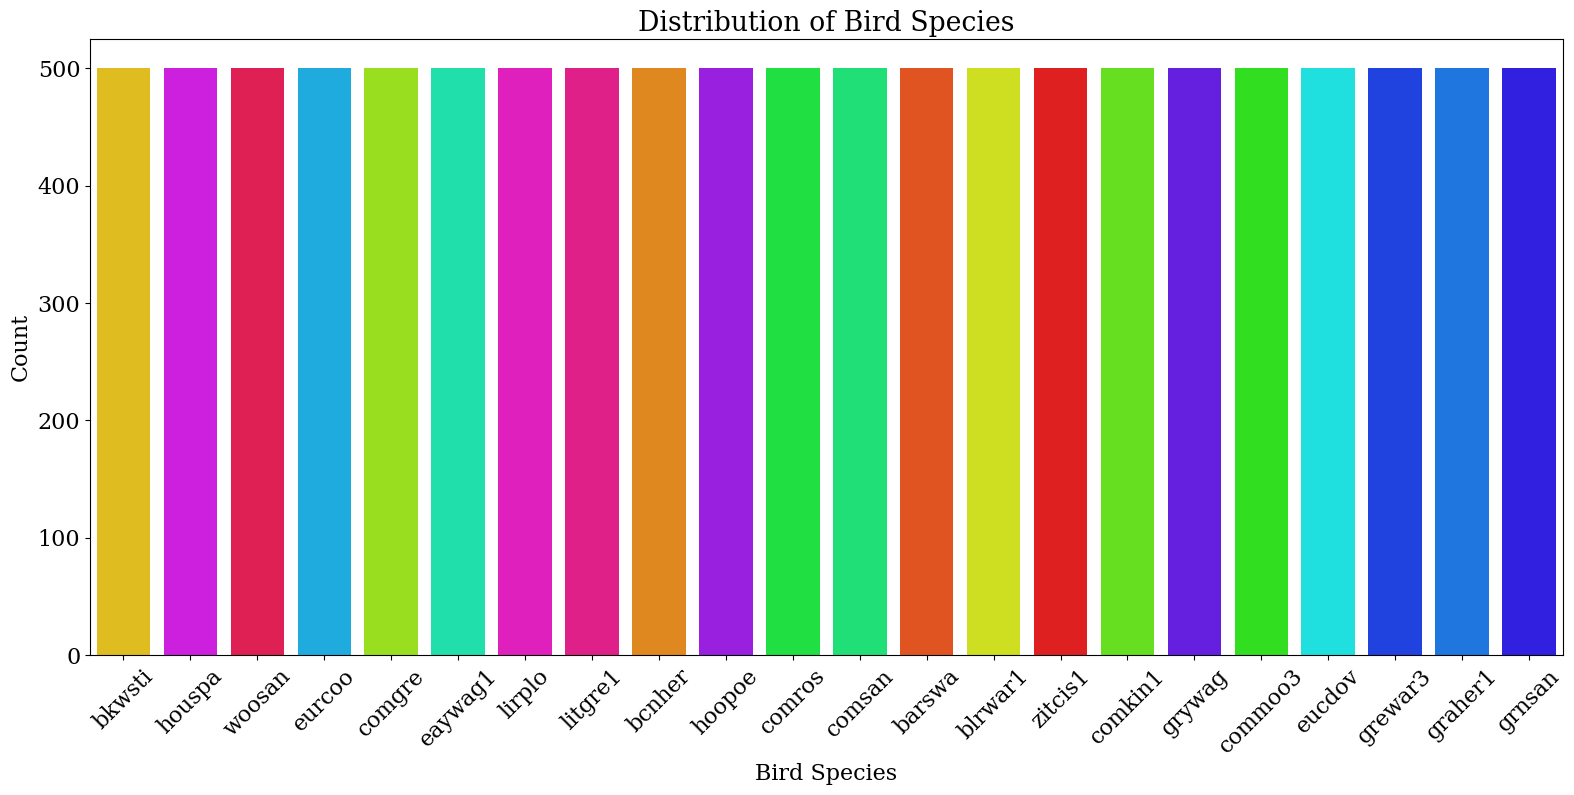

In [78]:
# Store data distribution chart
data_distribution_chart(df_in)

Obtenemos el dataframe de las vocalizaciones de especies con más repiticiones dentro del set de datos de la competición BirdCLEF 2024.

In [79]:
# Retrieve an input dataframe that considers classes with most samples
df_in = get_df_classes_max_count(df_in)

[INFO] Create the dataframe of interest with (11000, 2) dimensions
[INFO] Dataframe memory usage: 2.1 MB


Ejecutamos la visualización EDA con el fin de estudiar el balanceo de datos.

[INFO] Target bird labels: ['barswa' 'bcnher' 'bkwsti' 'blrwar1' 'comgre' 'comkin1' 'commoo3'
 'comros' 'comsan' 'eaywag1' 'eucdov' 'eurcoo' 'graher1' 'grewar3'
 'grnsan' 'grywag' 'hoopoe' 'houspa' 'lirplo' 'litgre1' 'woosan' 'zitcis1']
[INFO] Number of unique names of birds: 22
[INFO] Target bird classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


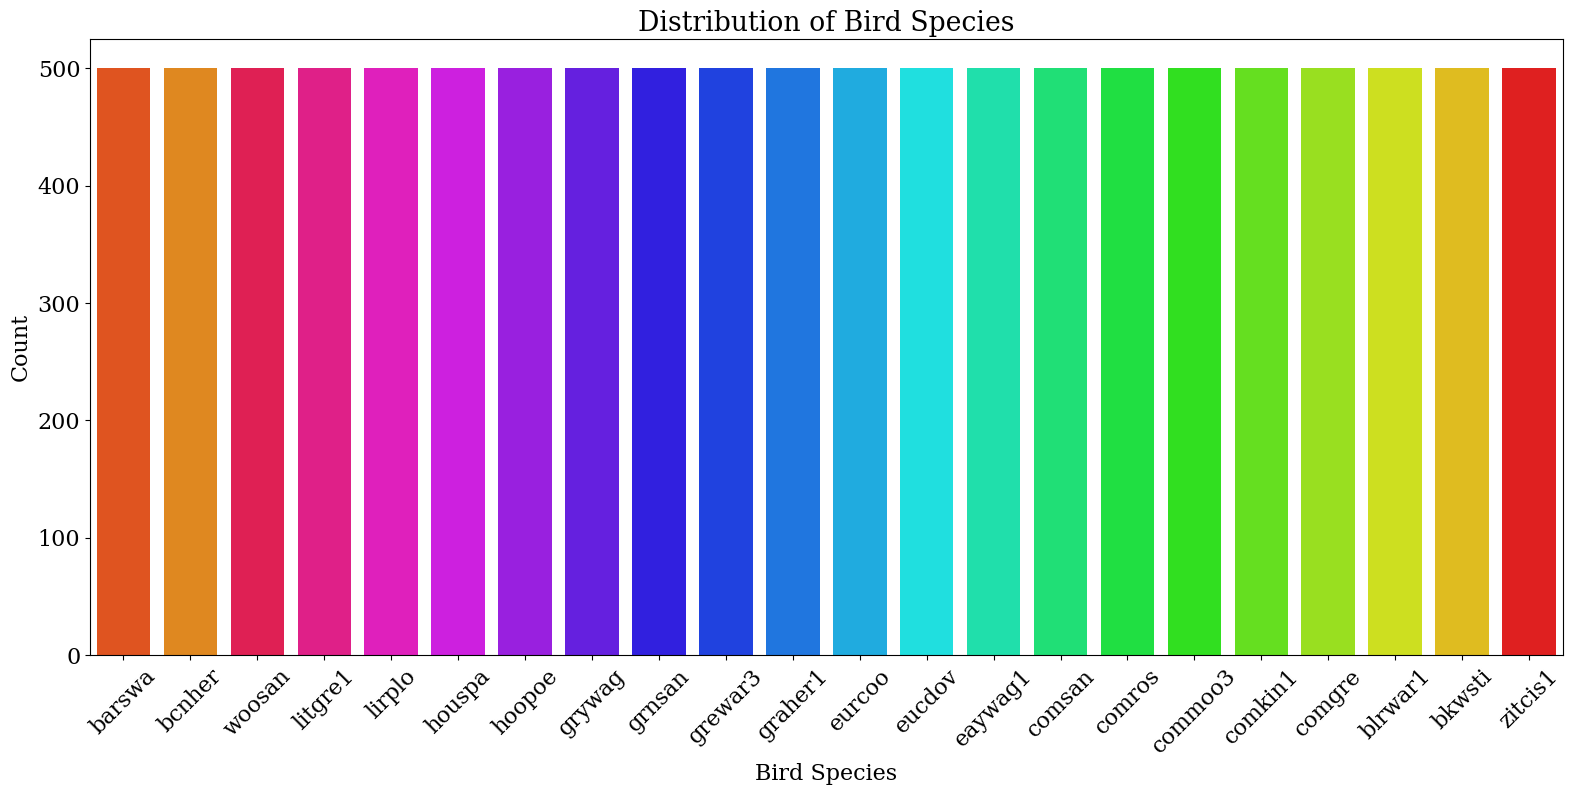

In [80]:
# Plot the data distribution chart using the maximum count dataframe
data_distribution_chart(df_in)

Actualizamos la lista de las rutas de las imágenes y sus respetivas etiquetadas para la extración de características de estas señales.

In [81]:
# Get dataframe of labels
df_labels = df_in.primary_label
# List of target labels
labels = df_labels.values.tolist()
# Get the filenames of WAV samples
filenames = df_in.filename.values.tolist()

### Procesamiento de imágenes

Definimos un índice de forma aleatoria para obtener una imagen de la lista correspondiente.

In [85]:
# define a random index of audio files
rand_value = random.sample(range(len(df_in)), 1)
index = int(rand_value[0])
img_file = os.path.join(train_dir, filenames[index])
label_file = labels[index]
img_file, label_file

('/data/fquiros/projects/birdCLEF24/datasets/train_imgs/grnsan/XC754737.png',
 'grnsan')

Cargamos y desplegamos la imagen determinada de forma aleatoria de la lista de imágenes.

[INFO] Loading spectral image 7376/11000 - filename=/data/fquiros/projects/birdCLEF24/datasets/train_imgs/grnsan/XC754737.png, class=grnsan, image size=(256, 256, 3)


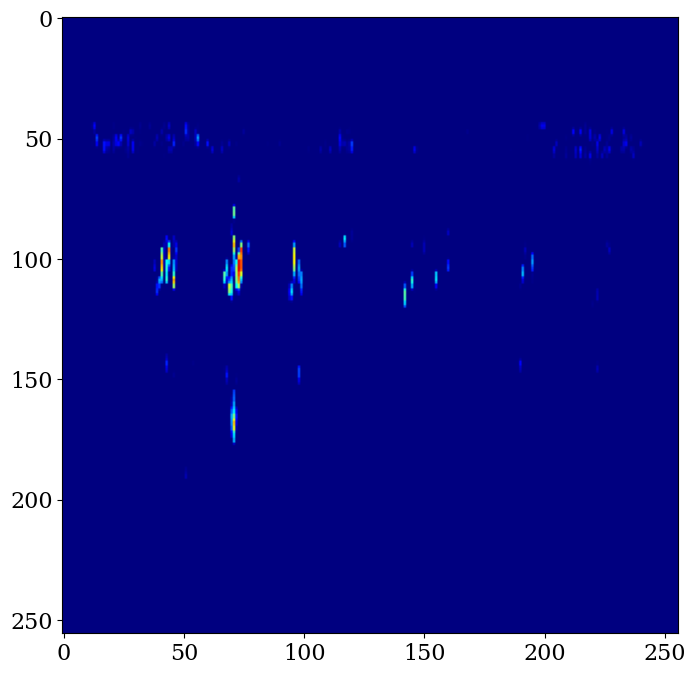

In [86]:
# get image data without changes
img = cv.imread(img_file, cv.IMREAD_UNCHANGED)
print('[INFO] Loading spectral image {}/{} - filename={}, class={}, image size={}'.format(index,
                                                                                          len(df_in),
                                                                                          filenames[index],
                                                                                          labels[index],
                                                                                          img.shape))
# plot the respective image data
plt.imshow(img)

Definimos un método que nos permita crear un arreglo de datos con las imágenes espectrales y sus correspondientes etiquetas a partir de la transcripción del set de datos.

In [87]:
def load_spectral_images(filename):
    # desired output parameters
    list_imgs, list_labels = list(), list()
    # Retrive filenames and labels from input data transcription
    df_in = load_dataset_file(filename, headers=['filename', 'primary_label'], dbg=False)
    # Get dataframe of labels
    df_labels = df_in.primary_label
    # List of target labels
    labels = df_labels.values.tolist()
    # Iterate through the filenames of WAV samples
    filenames = df_in.filename.values.tolist()
    # number of samples
    n_imgs = len(filenames)
    # main loop
    for i, fn in enumerate(filenames):
        # update filename
        filename = fn
        # get image without changes
        image = cv.imread(filename, cv.IMREAD_UNCHANGED)
        # get image label
        label = labels[i]
        print('[INFO] Loading spectral image {}/{} - filename={}, class={}, image size={}'.format(i + 1,
                                                                                                  n_imgs,
                                                                                                  filename,
                                                                                                  label,
                                                                                                  image.shape))
        # append image name to list
        list_imgs.append(image)
        # append label image to list
        list_labels.append(label)

    # how many spectral images did we get?
    print('[INFO] {} images'.format(len(list_imgs)))
    # a list of many time-frequency spectrograms is made into 1 big array
    data = np.array(list_imgs)
    # data array dimensions
    print('[INFO] {} image data array - dtype: {}'.format(data.shape, data.dtype))
    classes = np.array(list_labels)
    print('[INFO] {} labels array - dtype: {}'.format(classes.shape, classes.dtype))
    # delete function objects
    del labels, filenames, list_imgs, list_labels
    # run garbage collector
    gc.collect()
    # return data array
    return data, classes

Generamos los arreglos de datos y etiquetas que utilizaremos para la minería de datos.

In [88]:
# Load spectral images data and its labels from the metadata file
data, classes = load_spectral_images(meta_file)

[INFO] Display number of samples per class:
primary_label
bkwsti     500
houspa     500
woosan     500
eurcoo     500
comgre     500
eaywag1    500
lirplo     500
litgre1    500
bcnher     500
hoopoe     500
comros     500
comsan     500
barswa     500
blrwar1    500
zitcis1    500
comkin1    500
grywag     500
commoo3    500
eucdov     500
grewar3    500
graher1    500
grnsan     500
Name: count, dtype: int64
[INFO] Number of unique names of birds: 22
[INFO] Loading /data/fquiros/projects/birdCLEF24/datasets/20240918-194057_train_imgs.csv file as DF of (11000, 2) shape...
[INFO] Dataframe memory usage: 2.1 MB
[INFO] Loading spectral image 1/11000 - filename=/data/fquiros/projects/birdCLEF24/datasets/train_imgs/bkwsti/XC413271.png, class=bkwsti, image size=(256, 256, 3)
[INFO] Loading spectral image 2/11000 - filename=/data/fquiros/projects/birdCLEF24/datasets/train_imgs/bkwsti/XC721370.png, class=bkwsti, image size=(256, 256, 3)
[INFO] Loading spectral image 3/11000 - filename=/data/f

## Minería de datos

Definimos un método que nos permite vectorizar el arreglo de datos de entrada.

In [89]:
def data_vectorization(data):
    # depth: grayscale
    zdim = 1
    # vectorize
    dims = data.shape
    # image data
    if len(dims) == 4:
        # dims: N (samples), ydim (height), xdim (width), zdim (depth)
        N, ydim, xdim, zdim = dims
    # time-series data
    else:
        # dims: N (samples), ydim (features), xdim (timesteps)
        N, ydim, xdim = dims
    # reshape input array
    data = data.reshape(N, xdim * ydim * zdim)
    print('[INFO] Vector data size: {}, dtype: {}'.format(data.shape, data.dtype))
    # return data vector
    return data, xdim, ydim, zdim

Ejecutamos la rutina de vectorización para cada una de las entradas del arreglo de datos.

In [90]:
# Data mining: vectorization
data, width, height, depth = data_vectorization(data)

[INFO] Vector data size: (11000, 196608), dtype: uint8


### Escalamiento de datos

Instanciamos un método que estandariza un vector de datos.

In [91]:
def data_standardization(data):
    # standardize
    scaler = StandardScaler(copy=False)
    data = scaler.fit_transform(data)
    del scaler
    gc.collect()
    print('[INFO] Standardized vector size: {}, dtype: {}'.format(data[0:1].shape, data.dtype))
    return data

Definimos también una función que normaliza un vector de datos.

In [92]:
def data_normalization(data, norm='l2'):
    # normalization scaling
    scaler = Normalizer(norm=norm, copy=False)
    data = scaler.fit_transform(data)
    del scaler
    gc.collect()
    print('[INFO] Normalized (norm={}) data size: {}, dtype: {}'.format(norm, data[0:1].shape, data.dtype))
    return data

Declaramos un método que efectúa la normalización min-max al vector de datos.

In [93]:
def data_min_max_scaling(data, min_max):
    # min-max scaling
    scaler = MinMaxScaler(feature_range=min_max, copy=False)
    data = scaler.fit_transform(data)
    del scaler
    gc.collect()
    print('[INFO] Min-Max Scaled data size: {}, dtype: {}'.format(data[0:1].shape, data.dtype))
    return data

Instanciamos una función para aplicar el escalamiento máximo-absoluto a un vector de datos.

In [94]:
def data_max_abs_scaling(data):
    # max-abs scaling
    scaler = MaxAbsScaler(copy=False)
    data = scaler.fit_transform(data)
    del scaler
    gc.collect()    
    print('[INFO] Max-Abs Scaled data size: {}, dtype: {}'.format(data[0:1].shape, data.dtype))
    return data

Establecemos el método principal que implementa los métodos de escalamiento de datos.

In [95]:
def data_scaling(data, dtype, scaler=None, min_max=(-1, 1)):
    # Execute data scaling
    if scaler == 'min_max':
        # Minimum-maximum normalization
        data = data_min_max_scaling(data, min_max=min_max)
    elif scaler == 'max_abs':
        # Maximum-absolute normalization
        data = data_max_abs_scaling(data)
    elif scaler == 'norm_max':
        # Maximum normalization
        data = data_normalization(data, norm='max')
    elif scaler == 'norm_l1':
        # L1 normalization
        data = data_normalization(data, norm='l1')
    elif scaler == 'norm_l2':
        # L2 normalization
        data = data_normalization(data, norm='l2')
    elif scaler == 'norm':
        # Default normalization
        data = data_normalization(data)
    elif scaler == 'std':
        # Standardization
        data = data_standardization(data)
    else:
        print('[INFO] Unscaled vector size: {}, dtype: {}'.format(data[0:1].shape, data.dtype))
    # Set output data type
    data = data.astype(dtype)
    # Return data array
    return data

Execute scaling method to the data vector.

In [96]:
# 'min_max': NO
# 'max_abs': YES
# 'norm_max': YES
# 'norm_l1': NO
# 'norm' & 'norm_l2': NO
# 'std': YES
# Default: 'std'
data_type = 'float32' # vector data type
dscaler = None # data scaler option
# Data mining: scaling
data = data_scaling(data, data_type, dscaler)

[INFO] Unscaled vector size: (1, 196608), dtype: uint8


Declare a function to plot samples from a large data vector with its corresponding class label.

In [97]:
def data_plotting(data,
                  y_dim, x_dim, n_ch,
                  path=None,
                  tag=None,
                  classes=None,
                  grid_rows=3, grid_cols=3, color_map='jet'):
    # Init
    fig = plt.figure()
    # Generate random sample indexes
    len_data = len(data)
    samples_range = range(len_data)
    # Grid dimensions: 3x3 by default
    n_samples = grid_rows * grid_cols
    # Adjust number of samples with the data length
    if len_data < n_samples:
        n_samples = len_data
    # Create data grid
    rand_index = random.sample(samples_range, n_samples)
    for i in range(0, n_samples):
        sample_id = rand_index[i]
        sample = data[sample_id]
        plt.subplot(grid_rows, grid_cols, i + 1)
        if isinstance(sample, tuple):
            # Batch data tuple
            spec, sample_label = sample
            # Take one spectrogram from the batch
            spec = spec[0]
            sample_label = sample_label[0]
        else:
            # Single data sample
            spec = sample
            if classes is not None:
                sample_label = classes[sample_id]
            else:
                sample_label = sample_id
        # Spectral image
        spectrogram = np.reshape(spec, (y_dim, x_dim, n_ch))
        # Avoid 3-dimension for plotting
        img = spectrogram[:, :, 0]
        # Set a title for image batch title
        plt.title('Sample: {}, Label: {}'.format(sample_id + 1, sample_label))
        # Plot using colormap
        if n_ch == 1:
            plt.imshow(img, cmap=plt.get_cmap('gray'))
        else:
            plt.imshow(img, cmap=plt.get_cmap(color_map))
    
    # Keep spacing between subplots
    fig.tight_layout()
    # Show or store the corresponding figure
    if path is None:
        # Show data batch image
        plt.show()
    else:
        if tag is None:
            # Set timestamp tag
            tag = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
        # Create filename of the plot
        f_name = '{}_img_batch.pdf'.format(tag)
        # Datafile path
        img_path = os.path.join(path, f_name)
        # Save plot file
        fig.savefig(img_path)
        print('[INFO] Saving data batch plot file: {}'.format(img_path))
        plt.close(fig)
    # Delete function objects
    del fig, img, spectrogram, spec, sample
    # Run garbage collector
    gc.collect()

Finalmente, producimos una visualización con imágenes y clases selecionadas de forma aleatoria.

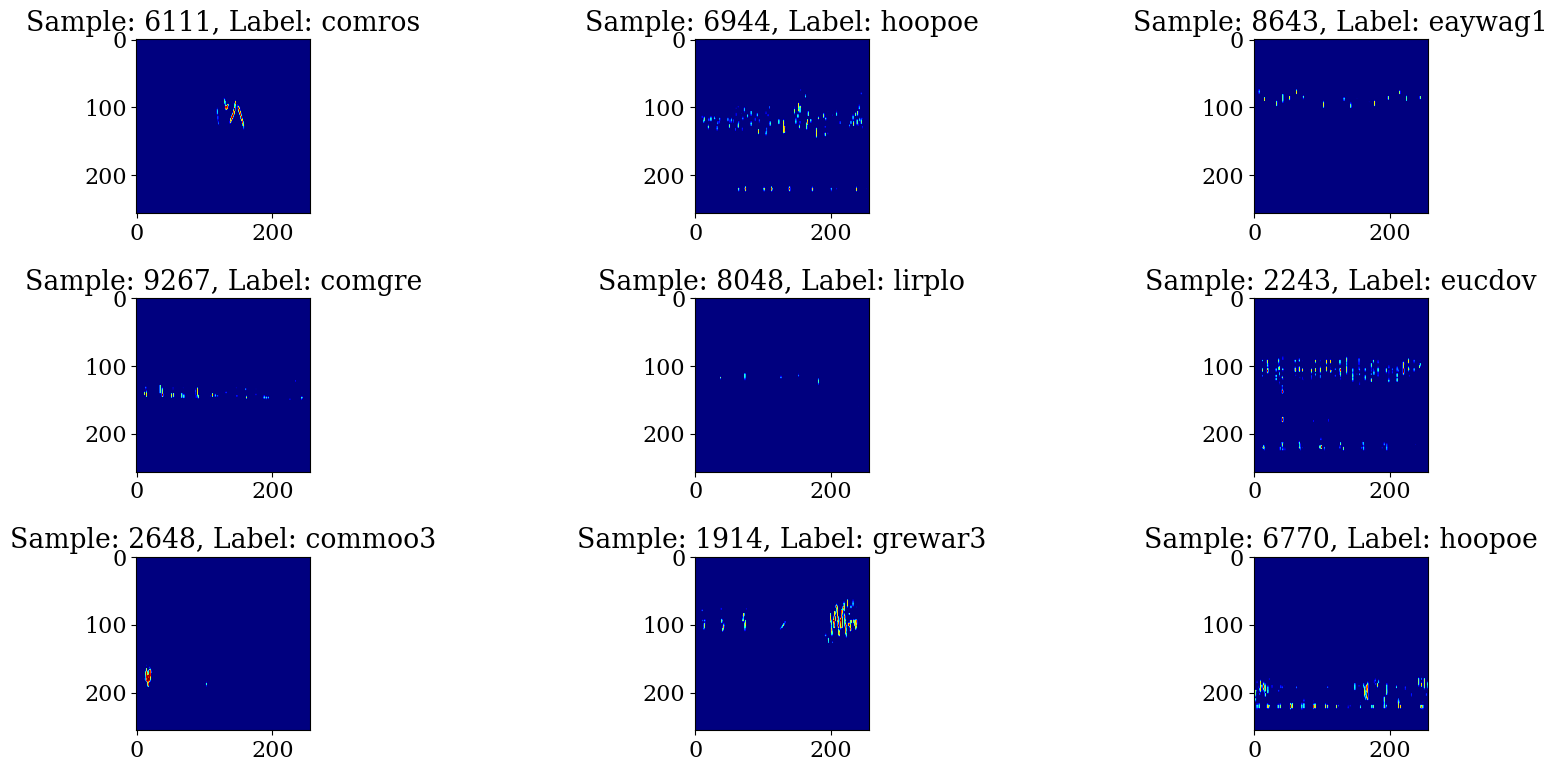

In [99]:
# EDA: random sample of data vector
data_plotting(data=data, y_dim=height, x_dim=width, n_ch=depth, classes=classes)

### Codificación de datos

Definimos ahora un método para codificar las classes en un arreglo de etiquetas numéricas.

In [100]:
def label_encoding(labels, data_type, to_col=False):
    # label encoding
    encoder = LabelEncoder()
    encoder.fit(labels)
    # we keep (and print) the number of classes
    target_classes = list(encoder.classes_)
    print('[INFO] {} classes - {}'.format(len(target_classes), target_classes))
    enc_labels = encoder.transform(labels)
    if to_col:
        # make a row vector a column vector
        classes_num = enc_labels.reshape(-1, 1)
    else:
        classes_num = enc_labels
    # update labels data type
    classes_num = classes_num.astype(data_type)
    print('[INFO] Ordinal scheme size: {}, dtype={}'.format(classes_num.shape, classes_num.dtype))
    # delete encoding object
    del encoder
    # run garbage collector
    gc.collect()
    return classes_num, target_classes

Instanciamos el método de codificación One-Hot para la transformación de etiquetas numéricas a un esquema de codificación binaria.

In [101]:
def one_hot_encoding(classes_num, data_type):
    # make a row vector to a column vector, as needed by OneHotEncoder, using reshape(-1,1)
    target = classes_num.reshape(-1, 1)
    # one-hot encoding
    encoder = OneHotEncoder(sparse_output=False)
    encoder.fit(target)
    classes_num_1hot = encoder.transform(target)
    # update data type
    classes_num_1hot = classes_num_1hot.astype(data_type)
    print('[INFO] One-Hot scheme size: ({}, {}), dtype={}'.format(classes_num_1hot.shape[0],
                                                                  classes_num_1hot.shape[1],
                                                                  classes_num_1hot.dtype))
    # delete encoding object
    del encoder
    # run garbage collector
    gc.collect()
    return classes_num_1hot

Ejecutamos la rutina de codificación de etiquetas usando el esquema One-Hot.

In [102]:
# Data mining: encoding
one_hot = True
if one_hot:
    # Run One-Hot scheme
    classes_num, target_labels = label_encoding(classes, data_type)
    classes_num = one_hot_encoding(classes_num, data_type)
else:
    # Ordinal scheme
    classes_num, target_labels = label_encoding(classes, data_type, to_col=True)
print('[INFO] BIRDs classes array: dtype={}, shape={}, nan={}'.format(classes_num.dtype, classes_num.shape,
                                                                      np.isnan(classes_num).any()))    

[INFO] 22 classes - ['barswa', 'bcnher', 'bkwsti', 'blrwar1', 'comgre', 'comkin1', 'commoo3', 'comros', 'comsan', 'eaywag1', 'eucdov', 'eurcoo', 'graher1', 'grewar3', 'grnsan', 'grywag', 'hoopoe', 'houspa', 'lirplo', 'litgre1', 'woosan', 'zitcis1']
[INFO] Ordinal scheme size: (11000,), dtype=float32
[INFO] One-Hot scheme size: (11000, 22), dtype=float32
[INFO] BIRDs classes array: dtype=float32, shape=(11000, 22), nan=False


Establecemos un método que nos permite generar información sobre el balance de clases.

In [103]:
def get_data_balance(classes_num, dtag='DATA'):
    # verify one-hot encoding
    one_hot = (classes_num.shape[1] != 1)
    # get row vectors of ground truth and prediction column vectors
    if one_hot:
        # decode one-hot scheme
        cnt_classes = np.argmax(classes_num, axis=1)
    else:
        # decode ordinal scheme
        cnt_classes = classes_num.reshape(1, -1)[0]
    # verify amount of samples per class in data SPLIT
    cnt_classes = cnt_classes.tolist()
    # create counter object
    cnt_obj = Counter(cnt_classes)
    print('[INFO] Number of samples for each category in {} set:'.format(dtag))
    for k in sorted(cnt_obj.keys()):
        print('[INFO] {}:{}'.format(int(k), cnt_obj[k]))
    return cnt_obj, cnt_classes

Obtenemos el balanceo de clases actual que manejamos en nuestro arreglo de etiquetas.

In [104]:
_, _ = get_data_balance(classes_num)

[INFO] Number of samples for each category in DATA set:
[INFO] 0:500
[INFO] 1:500
[INFO] 2:500
[INFO] 3:500
[INFO] 4:500
[INFO] 5:500
[INFO] 6:500
[INFO] 7:500
[INFO] 8:500
[INFO] 9:500
[INFO] 10:500
[INFO] 11:500
[INFO] 12:500
[INFO] 13:500
[INFO] 14:500
[INFO] 15:500
[INFO] 16:500
[INFO] 17:500
[INFO] 18:500
[INFO] 19:500
[INFO] 20:500
[INFO] 21:500


### Partición de datos

Instanciamos un método que nos permita generar los porciones de datos etiquetados para entrenamiento, validación y pruebas.

In [105]:
def prepare_datasets(data,
                     classes_num,
                     y_dim,
                     x_dim,
                     n_channels,
                     test_size,
                     random_split,
                     n_splits=1):
    # Init: train-val-test splits
    X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []
    # Dataset splits:
    # 1. training data
    # 2. testing (evaluation) data
    # 3. validation data
    if random_split:
        # perform random split: train-test
        X_train, X_test, y_train, y_test = train_test_split(data,
                                                            classes_num,
                                                            test_size=test_size,
                                                            random_state=0,
                                                            stratify=classes_num)
        # delete input data-labels array
        del data, classes_num
        # run garbage collector
        gc.collect()
        # perform random split: train-val
        X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                          y_train,
                                                          test_size=test_size,
                                                          random_state=42,
                                                          stratify=y_train)
        print('[INFO] Random split - Training: {}'.format(len(X_train)))
        print('[INFO] Random split - Testing: {}'.format(len(X_test)))
        print('[INFO] Random split - Validation: {}'.format(len(X_val)))
    else:
        # perform stratified split: train-test
        splitter = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
        splits = splitter.split(data, classes_num)
        for train_index, test_index in splits:
            print('[INFO] Train-test stratified split - Training: {}'.format(len(train_index)))
            print('[INFO] Train-test stratified split - Testing: {}'.format(len(test_index)))
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = classes_num[train_index], classes_num[test_index]

        # perform stratified split: train-val
        splits = splitter.split(X_train, y_train)
        for train_index, val_index in splits:
            print('[INFO] Train-val stratified split - Training: {}'.format(len(train_index)))
            print('[INFO] Train-val stratified split - Validation: {}'.format(len(val_index)))
            X_train, X_val = data[train_index], data[val_index]
            y_train, y_val = classes_num[train_index], classes_num[val_index]
        # delete splitter object
        del splitter, data, classes_num
        # run garbage collector
        gc.collect()

    # 2D-array reshaping for TRAIN split
    print('[INFO] Reshape TRAIN input data {} back to matrix form...'.format(X_train.shape))
    X_train = X_train.reshape(X_train.shape[0], x_dim, y_dim, n_channels)
    print('[INFO] Done! TRAIN input data: shape={}, dtype={}'.format(X_train.shape, X_train.dtype))
    # 2D-array reshaping for TEST split
    print('[INFO] Reshape TEST input data {} back to matrix form...'.format(X_test.shape))
    X_test = X_test.reshape(X_test.shape[0], x_dim, y_dim, n_channels)
    print('[INFO] Done! TEST input data: shape={}, dtype={}'.format(X_test.shape, X_test.dtype))
    # 2D-array reshaping for VAL split
    print('[INFO] Reshape VAL input data {} back to matrix form...'.format(X_val.shape))
    X_val = X_val.reshape(X_val.shape[0], x_dim, y_dim, n_channels)
    print('[INFO] Done! VAL input data: shape={}, dtype={}'.format(X_val.shape, X_val.dtype))
    # Return data and label splits: train, test, and val
    return X_train, X_test, X_val, y_train, y_test, y_val

Ejecutamos la particiación del vector de datos etiquetados para el entrenamiento del modelo, su validación y la evaluación del mismo.

In [159]:
# Data mining: split data vector
test_size = 0.2
rand_split = True
print('[INFO] Split the dataset - Train set split: {}%, Test set split: {}%'.format((1-test_size)*100,
                                                                                    test_size*100))
train_set, test_set, val_set, \
    train_classes, test_classes, val_classes = prepare_datasets(data=data,
                                                                classes_num=classes_num,
                                                                y_dim=height,
                                                                x_dim=width,
                                                                n_channels=depth,
                                                                test_size=test_size,
                                                                random_split=rand_split)

[INFO] Split the dataset - Train set split: 80.0%, Test set split: 20.0%


MemoryError: Unable to allocate 1.29 GiB for an array with shape (1760, 196608) and data type float32

Realizamos un EDA de las particiones de los datos que hemos generado. Primero, el arreglo de entrenamiento:

In [ ]:
print('[INFO] Training Data Splits - X: {}, dtype: {}, y: {}, dtype: {}'.format(train_set.shape,
                                                                                train_set.dtype,
                                                                                train_classes.shape,
                                                                                train_classes.dtype))
_ = get_data_balance(train_classes, dtag='TRAIN')
# Plot raw data samples from the training split
data_plotting(data=train_set,
              y_dim=height, x_dim=width, n_ch=depth,
              tag='img_TRAIN', classes=train_classes)

Ahora, procedemos con el EDA para la partición de datos relacionada con la evaluación del modelo.

In [ ]:
print('[INFO] Testing Data Splits - X: {}, dtype: {}, y: {}, dtype: {}'.format(test_set.shape,
                                                                               test_set.dtype,
                                                                               test_classes.shape,
                                                                               test_classes.dtype))
_ = get_data_balance(test_classes, dtag='TEST')
# Plot raw data samples from the testing split
data_plotting(data=test_set,
              y_dim=height, x_dim=width, n_ch=depth,
              tag='img_TEST', classes=test_classes)

Realizamos finalmente el EDA para la partición de datos para la validación.

In [ ]:
print('[INFO] Validation Data Splits - X: {}, dtype: {}, y: {}, dtype: {}'.format(val_set.shape,
                                                                                  val_set.dtype,
                                                                                  val_classes.shape,
                                                                                  val_classes.dtype))
_ = get_data_balance(val_classes, dtag='VAL')
# Plot raw data samples from the validation split
data_plotting(data=val_set,
              y_dim=height, x_dim=width, n_ch=depth,
              tag='img_VAL', classes=val_classes)

### Aumentación de datos

Definimos un método que emplea la técnica de *bootstrapping* para generar muestras etiquetadas sintéticas.

In [158]:
def generate_synthetic_data(data, dtype, dtag, classes_num, n_samples=5000):
    # Init random state for resampling
    random_state = 42
    # Verify one-hot encoding
    one_hot = (classes_num.shape[1] != 1)
    # Inspect data balancing and get classes counter
    classes_cnt, tmp_list = get_data_balance(classes_num, dtag=dtag)
    # Update target labels
    classes_num = np.array(tmp_list)
    # Get associated classes
    classes = list(classes_cnt.keys())
    # Init - data arrays
    X_in, y_in = np.copy(data), np.copy(classes_num)
    # Main loop
    for cl in sorted(classes):
        # Get count value per class 'cl'
        count_val = classes_cnt[cl]
        # Determine the location by index of the data corresponding to certain class
        data_idx = np.where(classes_num == cl)[0].tolist()
        # Get data and labels per class from the input data
        X_class, y_class = data[data_idx], classes_num[data_idx]
        # Generate synthetic data using data-labels arrays
        n_resamp = abs(n_samples - count_val)
        # Verify the count of samples according to the expected samples to balance the dataset
        if count_val < n_samples:
            # Perform data upsampling
            X_tmp, y_tmp = resample(X_class, y_class, n_samples=n_resamp, random_state=random_state)
            # Increase random state value
            random_state += 1
        else:
            # Perform data downsampling
            X_tmp, y_tmp = X_class[:n_samples], y_class[:n_samples]
            in_idx = np.where(y_in == cl)[0].tolist()
            X_in, y_in = np.delete(X_in, in_idx, axis=0), np.delete(y_in, in_idx, axis=0)

        # Update synthetic data-labels
        X_in, y_in = np.concatenate((X_in, X_tmp)), np.concatenate((y_in, y_tmp))
        # Verify current state
        if random_state == 43:
            # Update random state
            random_state = 122

    # Data-labels output
    X_out, y_out = np.stack(X_in, axis=0).astype(dtype), np.stack(y_in, axis=0).astype(dtype)
    # restore label encoding for synthetic data
    if one_hot:
        y_out = self.one_hot_encoding(y_out, dtype)
    else:
        # update data type
        y_out = y_out.reshape(-1, 1).astype(dtype)

    # Display synthetic data balance
    _, _ = self.get_data_balance(y_out, dtag=dtag)
    # Final messages
    print('[INFO] Synth-WAV data output - X: {}, dtype: {}, NaNs: {}'.format(X_out.shape, X_out.dtype,
                                                                             np.isnan(X_out).any()))
    print('[INFO] Synth-labels output - y: {}, dtype: {}, NaNs {}'.format(y_out.shape, y_out.dtype,
                                                                          np.isnan(y_out).any()))
    # Return: synthetic data-labels pairs
    return X_out, y_out

Establecemos los argumentos de entrada para la etapa de balanceo de datos mediante generación de datos sintéticos.

In [156]:
# Number of synthentic samples
syn_samples = 500
# Define number of classes
n_classes = len(target_labels)
# Define number of samples per class
n_samples = syn_samples*n_classes
# Number of samples per class for training
train_samples = n_samples * (1 - test_size)
# Number of samples per class for testing
test_samples = int(n_samples * test_size)
# Number of samples per class for validation
val_samples = int(train_samples * test_size)
# Update training samples
train_samples = int(train_samples * (1 - test_size))
print('[INFO] Number of samples per class in splits - TRAIN:{}, VAL:{}, TEST:{}'.format(train_samples,
                                                                                        val_samples,
                                                                                        test_samples))

[INFO] Number of samples per class in splits - TRAIN:7040, VAL:1760, TEST:2200


Generamos un nuevo split de entrenamiento con datos etiquetados sintéticos.

In [157]:
# Generate synthetic data to balance the labeled TRAIN split
train_set, train_classes = generate_synthetic_data(train_set, data_type, 'TRAIN',
                                                   train_classes,
                                                   n_samples=train_samples)
# Plot raw and synthetic data samples from the training split
data_plotting(data=train_set,
              y_dim=height, x_dim=width, n_ch=depth,
              tag='img_synth_TRAIN', classes=train_classes)

[INFO] Number of samples for each category in TRAIN set:
[INFO] 0:320
[INFO] 1:320
[INFO] 2:320
[INFO] 3:320
[INFO] 4:320
[INFO] 5:320
[INFO] 6:320
[INFO] 7:320
[INFO] 8:320
[INFO] 9:320
[INFO] 10:320
[INFO] 11:320
[INFO] 12:320
[INFO] 13:320
[INFO] 14:320
[INFO] 15:320
[INFO] 16:320
[INFO] 17:320
[INFO] 18:320
[INFO] 19:320
[INFO] 20:320
[INFO] 21:320


MemoryError: Unable to allocate 4.92 GiB for an array with shape (6720, 256, 256, 3) and data type float32

Producimos un nuevo split de evaluación con datos etiquetados sintéticos.

In [ ]:
# Generate synthetic data to balance the labeled TEST split
test_set, test_classes = generate_synthetic_data(test_set, data_type, 'TEST',
                                                 test_classes,
                                                 n_samples=test_samples)
# Plot raw data samples from the testing split
data_plotting(data=test_set,
              y_dim=height, x_dim=width, n_ch=depth,
              tag='img_synth_TEST', classes=test_classes)

Generamos un nuevo split de validación con datos etiquetados sintéticos.

In [ ]:
# Generate synthetic data to balance the labeled VAL split
val_set, val_classes = generate_synthetic_data(val_set, data_type, 'VAL',
                                               val_classes,
                                               n_samples=val_samples)
# Plot raw data samples from the validation split
data_plotting(data=val_set,
              y_dim=height, x_dim=width, n_ch=depth,
              tag='img_synth_VAL', classes=val_classes)

# Modelos de clasificación

La presente sección corresponde a la implementación del multi-clasificador de especies de pájaros, empleando distintos modelos de redes neuronales profundas. Definimos un método para construir una DNN personalizada con FCLs:

In [ ]:
def dnn_model(model,
              dtype,
              input_shape,
              output_size,
              layers,
              units,
              dropout,
              regularization=L2(0.0001),
              hidden_activation='relu',
              output_activation='softmax'):
    # Init
    layer_index = 1
    # Adding Input layer
    model.add(Input(shape=input_shape, dtype=dtype))
    # Adding a FCL layer
    model.add(Dense(units,
                    activation=hidden_activation,
                    kernel_regularizer=regularization,
                    bias_regularizer=regularization))
    print('[INFO] FCL layer: {}, FCL depth: {}, FCL activation: {}'.format(layer_index,
                                                                           units,
                                                                           hidden_activation))
    # Add FC n-layers
    for i in range(layer_index + 1, layers + 1):
        # Update layer index
        layer_index = i
        # Adding a FCL layer
        model.add(Dense(units,
                        activation=hidden_activation,
                        kernel_regularizer=regularization,
                        bias_regularizer=regularization))
        print('[INFO] FCL layer: {}, FCL depth: {}, FCL activation: {}'.format(layer_index,
                                                                               units,
                                                                               hidden_activation))

    # Adding a Flatten layer
    model.add(Flatten())
    # Dropout layer (generalization)
    model.add(Dropout(dropout))
    # Output layer
    model.add(Dense(output_size,
                    activation=output_activation,
                    kernel_regularizer=regularization,
                    bias_regularizer=regularization))
    # Return custom DNN
    return model

Instanciamos una función que permite la construcción de una CNN.

In [ ]:
def cnn_2d_model(model,
                 dtype,
                 input_shape,
                 output_size,
                 layers,
                 units,
                 filters,
                 kernel_size,
                 dropout,
                 regularization=L2(0.0001),
                 hidden_activation='relu',
                 output_activation='softmax'):
    # Init
    layer_index = 1
    # Adding Input layer
    model.add(Input(shape=input_shape, dtype=dtype))
    # Adding a Convolution Layer
    model.add(Conv2D(filters=filters,
                     kernel_size=kernel_size,
                     padding='same',
                     activation=hidden_activation,
                     kernel_regularizer=regularization,
                     bias_regularizer=regularization))
    # Adding an Max-Pooling Layer
    model.add(MaxPool2D(pool_size=2, strides=2))
    print('[INFO] CNN layer: {}, CNN depth: {}, CNN kernel size: {}'.format(layer_index,
                                                                            filters,
                                                                            (kernel_size, kernel_size)))
    # Add n-convolutional layers
    for i in range(layer_index + 1, layers + 1):
        # Update layer index
        layer_index = i
        # Update filters value
        filters *= 2
        # Update kernel size value
        kernel_size += 2
        # Adding a Convolution Layer
        model.add(Conv2D(filters=filters,
                         kernel_size=kernel_size,
                         padding='same',
                         activation=hidden_activation,
                         kernel_regularizer=regularization,
                         bias_regularizer=regularization))
        # Adding an Max-Pooling Layer
        model.add(MaxPool2D(pool_size=2, strides=2))
        print('[INFO] CNN layer: {}, CNN depth: {}, CNN kernel size: {}'.format(layer_index,
                                                                                filters,
                                                                                (kernel_size, kernel_size)))

    # Global pooling instead of flatten()
    model.add(Flatten())
    # FCL layer
    model.add(Dense(units,
                    kernel_regularizer=regularization,
                    bias_regularizer=regularization))
    # Dropout the layer (generalization)
    model.add(Dropout(dropout))        
    # Output layer
    model.add(Dense(output_size,
                    activation=output_activation,
                    kernel_regularizer=regularization,
                    bias_regularizer=regularization))
    # Return custom CNN
    return model

## Construcción del modelo

Establecemos una rutina que permita ensamblar diferentes arquitecturas de modelos de red neuronal.

In [ ]:
def create_model(model_type,
                 data_type,
                 input_shape,
                 num_classes,
                 num_layers,
                 num_units,
                 dropout,
                 num_filters=None,
                 kernel_size=None,
                 seed=1001):
    # make results repeatable
    set_random_seed(seed)
    # input layer - sequential model
    model = Sequential()
    # check model type
    if model_type == 'dnn':
        # Create custom ANN model
        model = dnn_model(model,
                          data_type,
                          input_shape,
                          num_classes,
                          num_layers,
                          num_units,
                          dropout)
    elif model_type == 'cnn2d':
        # Create custom CNN-2D model
        model = cnn_2d_model(model,
                             data_type,
                             input_shape,
                             num_classes,
                             num_layers,
                             num_units,
                             num_filters,
                             kernel_size,
                             dropout)        
    # else: transfer learning
    # return DL model
    return model

Definimos ahora el tamaño de la entrada del modelo y el de su salida.

In [ ]:
# Define mode input shape for image processing analysis: (height x width x depth)}
input_shape = (train_set.shape[1], train_set.shape[2], train_set.shape[3])
# Define model output size
output_size = train_classes.shape[1]
input_shape, output_size

Establecemos hiper-parámetros para la construcción del modelo de redes neuronales.

In [ ]:
# Define DL model type
model_type = 'cnn2d'
# Define layers hyper-parameter as input argument
layers = 7
# Define neurons hyper-parameter as input argument
units = 32
# Define generalization magnitude
dropout = 0.4

Ejecutamos la creación de la arquitectura de redes neuronales.

In [ ]:
# Init
model = None
# Create a DNN architecture
model = create_model(model_type,
                     data_type,
                     input_shape,
                     output_size,
                     layers,
                     units,
                     dropout)

## Compilación del modelo

Instanciamos un método que nos permite realizar la compilación del modelo construido.

In [140]:
def compile_model(model, opt, lr, loss, metrics, dtype, mm=0.0):
    # Init loss: cross-entropy (classification problems)
    cross_entropy = loss
    # Init metrics: accuracy (multiple classification)
    accuracy = metrics
    # Init optimizer
    optimizer = opt

    # Update loss function to categorical crossentropy
    if cross_entropy == 'binary_crossentropy':
        loss = BinaryCrossentropy(name=cross_entropy, from_logits=False)

    # Update loss function to categorical crossentropy
    if cross_entropy == 'categorical_crossentropy':
        loss = CategoricalCrossentropy(name=cross_entropy, from_logits=False)

    # Update metrics function to categorical accuracy
    if accuracy == 'binary_accuracy':
        metrics = BinaryAccuracy(name=accuracy, dtype=dtype)

    # Update metrics function to categorical accuracy
    if accuracy == 'categorical_accuracy':
        metrics = CategoricalAccuracy(name=accuracy, dtype=dtype)

    # Update optimizer to SGD
    if opt == 'sgd':
        optimizer = SGD(learning_rate=lr, momentum=mm)

    # Update optimizer to RMSprop
    if opt == 'rms':
        optimizer = RMSprop(learning_rate=lr, momentum=mm)

    # Update optimizer to Adam
    if opt == 'adam':
        optimizer = Adam(learning_rate=lr)

    # Compiling model
    model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])

    # Return compiled model
    return model

Establecemos hiper-parámetros ahora para la compilación del modelo de redes neuronales.

In [141]:
# Define optimizer function
optimizer = 'adam' # used for multi-classification
# Define learning rate
learning_rate = 1e-5
# Define momentum magnitude
momentum = 0.55
# Define loss function
loss = 'categorical_crossentropy'
# Define metrics function
metrics = 'categorical_accuracy'

Ejecutamos la compilación del modelo construido.

In [142]:
# Compile model: DNN network
model = compile_model(model,
                      optimizer,
                      learning_rate,
                      loss,
                      metrics,
                      dtype=data_type,
                      mm=momentum)

Desplegamos un resumen del modelo construido.

In [143]:
# Display model info summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256, 256, 32)      128       
                                                                 
 dense_21 (Dense)            (None, 256, 256, 32)      1056      
                                                                 
 dense_22 (Dense)            (None, 256, 256, 32)      1056      
                                                                 
 dense_23 (Dense)            (None, 256, 256, 32)      1056      
                                                                 
 dense_24 (Dense)            (None, 256, 256, 32)      1056      
                                                                 
 dense_25 (Dense)            (None, 256, 256, 32)      1056      
                                                                 
 dense_26 (Dense)            (None, 256, 256, 32)     

## Entrenamiento del modelo

Instanciamos un método genérico que nos permite obtener y visualizar las métricas durante el entrenamiento y la evaluación de nuestro modelo.

In [122]:
def save_model_metrics(history, metric, file_dir=None, tag=None, history_ft=None, ext='pdf'):
    # init metrics plot
    fig = plt.figure()
    # compute latest epoch
    latest_epoch = history.epoch[-1] + 1
    # create vectors for train and val metrics
    train_metric = history.history[metric]
    val_metric = history.history['val_{}'.format(metric)]
    # add fine-tune history
    if history_ft is not None:
        train_metric += history_ft.history[metric]
        val_metric += history_ft.history['val_{}'.format(metric)]
    # create plot labels for both functions
    train_label = 'train {}'.format(metric)
    val_label = 'val {}'.format(metric)
    # create metric plot
    plt.plot(train_metric, label=train_label)
    plt.plot(val_metric, label=val_label)
    # plot where the fine tune starts
    if history_ft is not None:
        plt.plot([latest_epoch, latest_epoch],
                 plt.ylim([0, 1.0]), label='fine-tuning start')
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(metric))
    if metric == 'loss':
        plt.legend(loc='upper right')
    else:
        plt.legend(loc='lower right')
    plt.title('Train-val: {}'.format(tag))
    # enable grid
    plt.grid(True)
    # check filedir
    if file_dir is None:
        # show data batch image
        plt.show()
    else:        
        # metrics timestamp
        ts = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
        # set tag as the metric string
        if tag is None:
            tag = metric
        # define filepath
        file_path = os.path.join(file_dir, '{}_{}.{}'.format(ts, tag, ext))
        # store accuracy plot
        fig.savefig(file_path)
        print('[INFO] Saving {} plot file: {}'.format(metric, file_path))
        plt.close(fig)

    # Free memory space
    del fig
    gc.collect()

Definimos los hiper-parámetros del entrenamiento del modelo de redes neuronales.

In [144]:
# Init
cbs = None
# Define a validation split ratio during fit
val_split = 0.0
# Define the number of sables per gradient update
batch_size = 64
# Define the number of training iterations
epochs = 50
# Define arguments for early stopping callback
patience, min_delta = 5, 0.0001

Declaramos de igual forma las llamadas que implementamos durante el entrenamiento.

In [145]:
# callbacks
cbs = list()
# early stopping callback
es_callback = EarlyStopping(monitor='val_{}'.format(loss),
                            min_delta=min_delta,
                            patience=patience)
# append to list
cbs.append(es_callback)
# learning rate reduction on-plateau
lr_callback = ReduceLROnPlateau(monitor='val_{}'.format(loss),
                                min_delta=min_delta,
                                patience=patience)
# append to list
cbs.append(lr_callback)

Ejecutamos la función relacionada con el entrenamiento del modelo construido y compilado.

In [146]:
# create validation set tuple
val_data = (val_set, val_classes)
# for training, we need the "1 hot encoded" numeric classes of the ground truth
History = model.fit(x=train_set,
                    y=train_classes,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=cbs,
                    validation_split=val_split,
                    validation_data=val_data)

Epoch 1/50


2024-09-18 19:57:50.096030: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f589fbf7f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-18 19:57:50.096105: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-09-18 19:57:51.032753: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-18 19:57:53.065058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2024-09-18 19:57:59.121610: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 [==============================] - 41s 132ms/step - loss: 22.6440 - categorical_accuracy: 0.0496 - categorical_crossentropy: 21.0954 - val_loss: 14.3518 - val_categorical_accuracy: 0.0460 - val_categorical_crossentropy: 14.2867 - lr: 1.0000e-05
Epoch 2/50
110/110 [==============================] - 12s 105ms/step - loss: 15.5813 - categorical_accuracy: 0.0422 - categorical_crossentropy: 13.8537 - val_loss: 8.9131 - val_categorical_accuracy: 0.0466 - val_categorical_crossentropy: 8.8619 - lr: 1.0000e-05
Epoch 3/50
110/110 [==============================] - 12s 107ms/step - loss: 9.3869 - categorical_accuracy: 0.0432 - categorical_crossentropy: 8.1884 - val_loss: 5.2934 - val_categorical_accuracy: 0.0466 - val_categorical_crossentropy: 5.2588 - lr: 1.0000e-05
Epoch 4/50
110/110 [==============================] - 12s 105ms/step - loss: 5.5377 - categorical_accuracy: 0.0482 - categorical_crossentropy: 4.8814 - val_loss: 3.6641 - val_categorical_accuracy: 0.0460 - val_categorical_cro

Revisemos los resultados de nuestro entrenamiento y su validación.

In [148]:
# get validation accuracy scores per epoch as a data aray
val_acc_per_epoch = History.history['val_{}'.format(metrics)]
# get max accuracy score during epochs
max_val_acc = max(val_acc_per_epoch)
# get the number of epoch related to the max validation accuracy
best_epoch = val_acc_per_epoch.index(max_val_acc) + 1
print('[INFO] Training/Validation done! - best epoch: {}/{}, best validation score: {}'.format(best_epoch,
                                                                                               epochs,
                                                                                               max_val_acc))

[INFO] Training/Validation done! - best epoch: 2/50, best validation score: 0.046590909361839294
